# Import Library

In [115]:
import os
import sys
import numpy as np
import pandas as pd
import xarray as xr
import rasterio
from joblib import dump, load
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy import interpolate
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from extract_func.Extract_PTE_function import make_interpretor

# Show distribution of GNSS stations

In [6]:
US_gnss = pd.read_csv('../GNSS_US/US/GPS_stations/product2/gnssStationList_overbbox.csv')
Global_gnss = pd.read_csv('../GNSS/Global_dat/GNSS/gnssStationList_overbbox.csv')

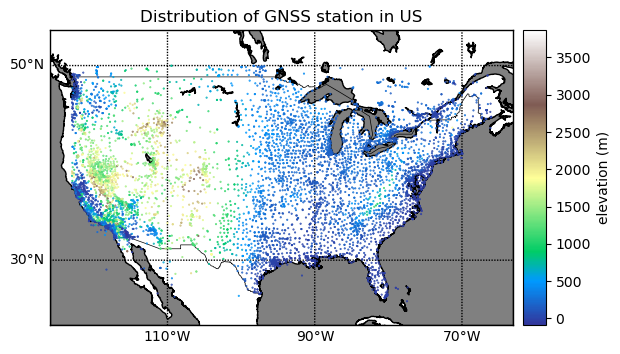

In [7]:
# day1 = day1[(day1['Lat'] >30) & (day1['Lat'] < 60) & ((day1['Lon'] > -120) & (day1['Lon'] < -60))]
lat = US_gnss['Lat']
lon = US_gnss['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 3 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=0,
            lon_0=0,
            projection='merc',
            resolution = 'i',
            area_thresh=1000
            )
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(-90,90,20)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True])
meridians = np.arange(10.,351.,20)
m.drawmeridians(meridians,labels=[True,False,False,True])
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = '.', s=1, zorder=5, c=US_gnss['Hgt_m'], cmap='terrain')
# plt.savefig('../../../AGU2022_plot/US_GNSS_dist.png', dpi=600)
m.colorbar(label='elevation (m)')
plt.title('Distribution of GNSS station in US')
plt.show()

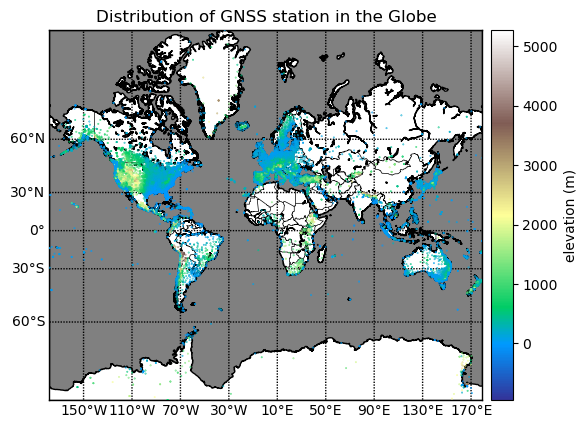

In [8]:
# day1 = day1[(day1['Lat'] >30) & (day1['Lat'] < 60) & ((day1['Lon'] > -120) & (day1['Lon'] < -60))]
lat = Global_gnss['Lat']
lon = Global_gnss['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 0 # buffer to add to the range
lat_min = -80
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=0,
            lon_0=0,
            projection='merc',
            resolution = 'i',
            area_thresh=1000
            )
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True])
meridians = np.arange(10.,351.,40)
m.drawmeridians(meridians,labels=[True,False,False,True])
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = '.', c=Global_gnss['Hgt_m'], cmap='terrain',s=0.5, zorder=5)
# plt.savefig('../../../AGU2022_plot/US_GNSS_dist.png', dpi=600)
m.colorbar(label='elevation (m)')
plt.title('Distribution of GNSS station in the Globe')
plt.show()

# Correlation of ZTD and altitude

In [2]:
new_test = pd.read_csv('../GNSS/Global_dat/Full_Global_data/test_global_PTE_vert_fixed_hgtlvs_with_pred.csv')

In [86]:
new_test

Unnamed: 0    ID        Date     ZTD  wet_delay  hydrostatic_delay  \
0          1082502  D143  2021-01-10  2.2784     0.0470             2.2314   
1          1082503  OHLC  2021-01-10  2.3306     0.0446             2.2860   
2          1082504  TGRI  2021-01-10  2.2803     0.1029             2.1774   
3          1082505  X059  2021-01-10  2.3109     0.0165             2.2944   
4          1082506  IABL  2021-01-10  2.3108     0.0415             2.2693   
...            ...   ...         ...     ...        ...                ...   
457475     1539977  J782  2022-10-17  2.3381     0.1235             2.2146   
457476     1539978  P080  2022-10-17  1.8765     0.0447             1.8318   
457477     1539979  GACE  2022-10-17  2.3348     0.1518             2.1830   
457478     1539980  TGBS  2022-10-17  2.4852     0.1728             2.3124   
457479     1539981  P397  2022-10-17  2.2313     0.0741             2.1572   

        times  sigZTD      Lat       Lon  ...      e_45      e_46      e_47  \
0           0  0.0026  50.7323   12.5203  ...  0.032060  0.027417  0.023558   
1           0  0.0026  41.7212  -83.5263  ...  0.033288  0.029017  0.025795   
2           0  0.0034 -38.9771  175.8585  ...  0.029205  0.023876  0.021358   
3           0  0.0037  34.8012  138.0731  ...  0.033044  0.028310  0.024358   
4           0  0.0027  40.7408  -92.4309  ...  0.033409  0.028564  0.024460   
...       ...     ...      ...       ...  ...       ...       ...       ...   
457475      0  0.0025  44.3651  142.2645  ...  0.039768  0.032811  0.027906   
457476      0  0.0023  39.1194 -114.2772  ...  0.043733  0.036500  0.029793   
457477      0  0.0027  34.5114  -83.5237  ...  0.041998  0.034082  0.028726   
457478      0  0.0026  53.5769    6.6614  ...  0.039257  0.032777  0.027944   
457479      0  0.0023  46.4216 -123.7992  ...  0.041095  0.034114  0.028796   

            e_48      e_49      e_50      e_51  rf_Model_prediction  \
0       0.012157  0.006304  0.002424 -0.001055             2.267286   
1       0.012191  0.006212  0.002963  0.001417             2.342560   
2       0.012107  0.006411  0.003133  0.000815             2.287976   
3       0.012449  0.006126  0.003159  0.000666             2.322539   
4       0.011663  0.006376  0.003002  0.001422             2.317579   
...          ...       ...       ...       ...                  ...   
457475  0.012748  0.006563  0.003218  0.001391             2.323491   
457476  0.012942  0.006629  0.003261  0.001381             1.872529   
457477  0.012957  0.006263  0.002832  0.001022             2.354305   
457478  0.013185  0.006485  0.003055  0.001409             2.459804   
457479  0.013295  0.006877  0.003150  0.001446             2.233227   

        nn_model_prediction    WM_ZTD  
0                  2.267729  2.273620  
1                  2.345321  2.355923  
2                  2.286639  2.301905  
3                  2.317984  2.325357  
4                  2.310547  2.335052  
...                     ...       ...  
457475             2.321986  2.341024  
457476             1.871174  1.891669  
457477             2.348444  2.367171  
457478             2.467183  2.470469  
457479             2.243631  2.254035  

[457480 rows x 167 columns]

In [3]:
one_date = new_test[new_test['Date']=='2021-01-25'].reset_index(drop=True)

In [4]:
one_date

Unnamed: 0    ID        Date     ZTD  wet_delay  hydrostatic_delay  \
0         1093335  D143  2021-01-25  2.2190     0.0394             2.1796   
1         1093336  OHLC  2021-01-25  2.3494     0.0780             2.2714   
2         1093337  TGRI  2021-01-25  2.3028     0.1302             2.1726   
3         1093338  X059  2021-01-25  2.3729     0.0605             2.3124   
4         1093339  IABL  2021-01-25  2.3205     0.0737             2.2468   
...           ...   ...         ...     ...        ...                ...   
10608     1103943  GACE  2021-01-25  2.3275     0.1315             2.1960   
10609     1103944  ATRU  2021-01-25  2.3871     0.0383             2.3488   
10610     1103945  TGBS  2021-01-25  2.3169     0.0486             2.2683   
10611     1103946  P397  2021-01-25  2.1864     0.0505             2.1359   
10612     1103947  PMAR  2021-01-25  1.7210     0.0068             1.7142   

       times  sigZTD      Lat       Lon  ...      e_45      e_46      e_47  \
0          0  0.0026  50.7323   12.5203  ...  0.032692  0.028593  0.025330   
1          0  0.0022  41.7212  -83.5263  ...  0.035130  0.030069  0.025780   
2          0  0.0036 -38.9771  175.8585  ...  0.036903  0.030921  0.025110   
3          0  0.0040  34.8012  138.0731  ...  0.035415  0.030229  0.025806   
4          0  0.0026  40.7408  -92.4309  ...  0.034432  0.030245  0.025901   
...      ...     ...      ...       ...  ...       ...       ...       ...   
10608      0  0.0024  34.5114  -83.5237  ...  0.034976  0.030567  0.026092   
10609      0  0.0027  47.1309   51.9538  ...  0.033299  0.028480  0.024508   
10610      0  0.0023  53.5769    6.6614  ...  0.034517  0.029573  0.024724   
10611      0  0.0024  46.4216 -123.7992  ...  0.034800  0.029842  0.025622   
10612      0  0.0024  43.9907 -121.6867  ...  0.034052  0.029937  0.025683   

           e_48      e_49      e_50      e_51  rf_Model_prediction  \
0      0.012363  0.006484  0.002100 -0.002192             2.210145   
1      0.011815  0.006050  0.003062  0.001452             2.344165   
2      0.012206  0.006324  0.003040  0.000612             2.306302   
3      0.011852  0.006091  0.003007  0.001318             2.402842   
4      0.011812  0.005830  0.003099  0.001485             2.311533   
...         ...       ...       ...       ...                  ...   
10608  0.011788  0.006054  0.003077  0.001345             2.350170   
10609  0.011715  0.005872  0.002935  0.001405             2.386413   
10610  0.012471  0.006520  0.002793  0.000026             2.309910   
10611  0.012196  0.006560  0.003183  0.001484             2.190067   
10612  0.011757  0.006312  0.003073  0.001480             1.732204   

       nn_model_prediction    WM_ZTD  
0                 2.213663  2.223226  
1                 2.342039  2.372200  
2                 2.306161  2.316832  
3                 2.397911  2.403546  
4                 2.316961  2.343931  
...                    ...       ...  
10608             2.329264  2.359295  
10609             2.413294  2.415010  
10610             2.311922  2.319097  
10611             2.193170  2.210764  
10612             1.735270  1.753918  

[10613 rows x 167 columns]

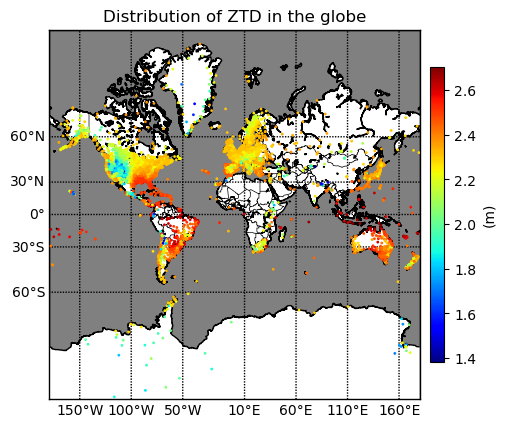

In [5]:
# day1 = day1[(day1['Lat'] >30) & (day1['Lat'] < 60) & ((day1['Lon'] > -120) & (day1['Lon'] < -60))]
lat = one_date['Lat']
lon = one_date['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 0 # buffer to add to the range
# lat_min = min(lat) - margin
# lat_max = max(lat) + margin
# lon_min = min(lon) - margin
# lon_max = max(lon) + margin
fig, axes = plt.subplots(1,1)
# create map using BASEMAP
m = Basemap(llcrnrlon=-180,
            llcrnrlat=-85,
            urcrnrlon=180,
            urcrnrlat=85,
            lat_0=0,
            lon_0=0,
            projection='merc',
            resolution = 'i',
            area_thresh=1000,
            ax=axes
            )
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True])
meridians = np.arange(10.,351.,50)
m.drawmeridians(meridians,labels=[True,False,False,True])
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, c=one_date['ZTD'], cmap='jet', s=1, zorder=3)
# plt.savefig('../../../AGU2022_plot/US_GNSS_dist.png', dpi=600)
fig.colorbar(a,ax=axes, label='(m)', pad=0.02, shrink=0.8)
axes.set_title('Distribution of ZTD in the globe')
plt.savefig('Plots/Dist_ZTD_glob.png', dpi=600)
plt.show()

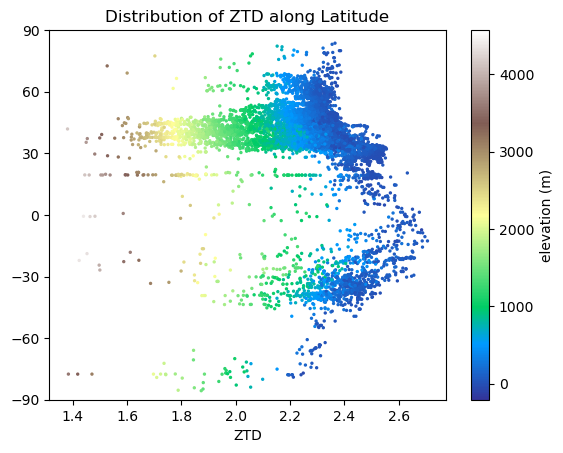

In [6]:
plt.scatter(one_date['ZTD'], one_date['Lat'],c=one_date['Hgt_m'], cmap='terrain', s=2)
plt.xlabel('ZTD')
plt.colorbar(label='elevation (m)')
plt.ylim(-90,90)
plt.yticks(np.arange(-90, 91, 30))
plt.title('Distribution of ZTD along Latitude')
plt.savefig('Plots/Dist_ZTD_Lat.png', dpi=600)
plt.show()

# Model Performance for CONUS Data

In [11]:
# Importing the libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Read in data
dat_US = pd.read_csv('../GNSS_US/US/PTE_vert_fixed_hgtlvs.csv')
dat_US = dat_US.dropna()

train_US = dat_US[dat_US['Date'] < '2021-01-01']
test_US = dat_US[dat_US['Date'] >= '2021-01-01']

x_train = train_US.iloc[:, train_US.columns.str.startswith(('Lat', 'Hgt_m','P_', 'T_', 'e_'))]
x_test = test_US.iloc[:, test_US.columns.str.startswith(('Lat', 'Hgt_m','P_', 'T_', 'e_'))]
y_train = train_US[['ZTD']]
y_test = test_US[['ZTD']]

In [84]:
test_US

ID        Date  DOY     ZTD  wet_delay  hydrostatic_delay  times  \
5670625  OHLC  2021-01-01    1  2.3294     0.0413             2.2881  39600   
5670626  IABL  2021-01-01    1  2.3344     0.0885             2.2459  39600   
5670627  PSU3  2021-01-01    1  2.2815     0.0273             2.2542  39600   
5670628  NEGO  2021-01-01    1  2.1586     0.0475             2.1111  39600   
5670629  BCKW  2021-01-01    1  2.3241     0.1182             2.2059  39600   
...       ...         ...  ...     ...        ...                ...    ...   
7763080  P172  2022-04-30  120  2.2531     0.0310             2.2221  39600   
7763081  KRAC  2022-04-30  120  1.7642     0.0263             1.7379  39600   
7763082  P080  2022-04-30  120  1.8732     0.0462             1.8270  39600   
7763083  P397  2022-04-30  120  2.2150     0.0643             2.1507  39600   
7763084  PMAR  2022-04-30  120  1.7773     0.0429             1.7344  39600   

         sigZTD      Lat       Lon  ...      e_45      e_46      e_47  \
5670625  0.0017  41.7212  -83.5263  ...  0.037172  0.031665  0.026855   
5670626  0.0017  40.7408  -92.4309  ...  0.037242  0.031752  0.026955   
5670627  0.0017  40.8069  -77.8498  ...  0.037259  0.031738  0.026932   
5670628  0.0018  40.9201 -100.1659  ...  0.036228  0.031519  0.026862   
5670629  0.0020  49.8848 -119.4954  ...  0.036592  0.031350  0.026782   
...         ...      ...       ...  ...       ...       ...       ...   
7763080  0.0018  36.2281 -121.7672  ...  0.034538  0.029687  0.026382   
7763081  0.0018  37.7133 -118.8805  ...  0.036563  0.031819  0.027232   
7763082  0.0015  39.1194 -114.2772  ...  0.034219  0.029529  0.026298   
7763083  0.0019  46.4216 -123.7992  ...  0.035888  0.031869  0.028361   
7763084  0.0018  43.9907 -121.6867  ...  0.036018  0.031969  0.028439   

             e_48      e_49      e_50      e_51  nn_model_prediction  \
5670625  0.012074  0.005457  0.002980 -0.000133             2.325704   
5670626  0.012177  0.005506  0.002845 -0.000139             2.324994   
5670627  0.012123  0.005934  0.002881  0.000521             2.279577   
5670628  0.012212  0.005502  0.002824 -0.000043             2.154335   
5670629  0.012314  0.005808  0.002909  0.001319             2.312625   
...           ...       ...       ...       ...                  ...   
7763080  0.012514  0.006626  0.003221  0.000475             2.262228   
7763081  0.012506  0.006627  0.003203  0.000412             1.764579   
7763082  0.012840  0.006843  0.003181  0.000552             1.876263   
7763083  0.012823  0.006850  0.003337  0.000578             2.220677   
7763084  0.012824  0.006840  0.003234  0.000238             1.788534   

         rf_model_prediction    WM_ZTD  
5670625             2.327218  2.345241  
5670626             2.322520  2.343962  
5670627             2.281915  2.298813  
5670628             2.157977  2.167268  
5670629             2.311394  2.327324  
...                      ...       ...  
7763080             2.281915  2.278753  
7763081             1.768664  1.776075  
7763082             1.877793  1.888181  
7763083             2.220608  2.230571  
7763084             1.780782  1.792841  

[2086682 rows x 167 columns]

In [12]:
# Load in the model
CONUS_rf_model = load('Model/US_PTE_fixed_hgtlvs_RF.joblib')
import tensorflow as tf
CONUS_nn_model = tf.keras.models.load_model('Model/US_PTE_fixed_hgtlvs_model/')
CONUS_scaler_x = load('Scaler/US_noGOES_MinMax_155_scaler_x.bin')

/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [13]:
CONUS_rf_predict = CONUS_rf_model.predict(x_test).reshape(-1,1)
CONUS_nn_predict = CONUS_nn_model.predict(CONUS_scaler_x.transform(x_test))
CONUS_true = y_test.values

65209/65209 [==============================] - 46s 701us/step


In [80]:
from sklearn.metrics import mean_squared_error, r2_score
print("RF model")
predict = CONUS_rf_predict
true = CONUS_true
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(true, predict))
print('Mean: %.5f' % np.mean(predict-true))

# The R2 score
print('R2: %.5f' % r2_score(true, predict))

# The RMSE
rmse = np.sqrt(mean_squared_error(true, predict))
print('RMSE: %.5f' % rmse)

errors = predict - true
MAE = np.mean(abs(errors))
print('MAE: %.5f' % MAE )

RF model
Mean squared error: 0.0003640105
Mean: 0.00101
R2: 0.98986
RMSE: 0.01908
MAE: 0.01474


In [79]:
from sklearn.metrics import mean_squared_error, r2_score
print("NN model")
predict = CONUS_nn_predict
true = CONUS_true
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(true, predict))
print('Mean: %.5f' % np.mean(predict-true))

# The R2 score
print('R2: %.5f' % r2_score(true, predict))

# The RMSE
rmse = np.sqrt(mean_squared_error(true, predict))
print('RMSE: %.5f' % rmse)

errors = predict - true
MAE = np.mean(abs(errors))
print('MAE: %.5f' % MAE )

NN model
Mean squared error: 0.0000764411
Mean: -0.00144
R2: 0.99787
RMSE: 0.00874
MAE: 0.00584


In [83]:
from sklearn.metrics import mean_squared_error, r2_score
print("WM model")
predict = test_US.WM_ZTD.values.reshape(-1,1)
true = CONUS_true
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(true, predict))
print('Mean: %.5f' % np.mean(predict-true))

# The R2 score
print('R2: %.5f' % r2_score(true, predict))

# The RMSE
rmse = np.sqrt(mean_squared_error(true, predict))
print('RMSE: %.5f' % rmse)

errors = predict - true
MAE = np.mean(abs(errors))
print('MAE: %.5f' % MAE )

WM model
Mean squared error: 0.0003598983
Mean: 0.01625
R2: 0.98997
RMSE: 0.01897
MAE: 0.01672


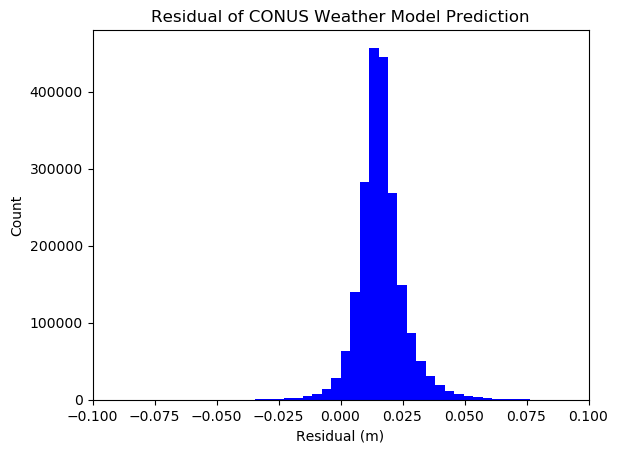

In [78]:
plt.hist(predict-true, bins=450, color='blue')
plt.title('Residual of CONUS Weather Model Prediction')
plt.xlabel('Residual (m)')
plt.ylabel('Count')
plt.xlim(-0.1, 0.1)
# plt.text(-0.08, 150000, 'RMSE: {:.5f} m\n MAE: {:.5f} m \n MEAN: {:.5f} m'.format(rmse, MAE, np.mean(rf_predict-true) ), fontsize = 8, 
#          bbox = dict(facecolor = 'white', alpha = 0.5))
plt.show()

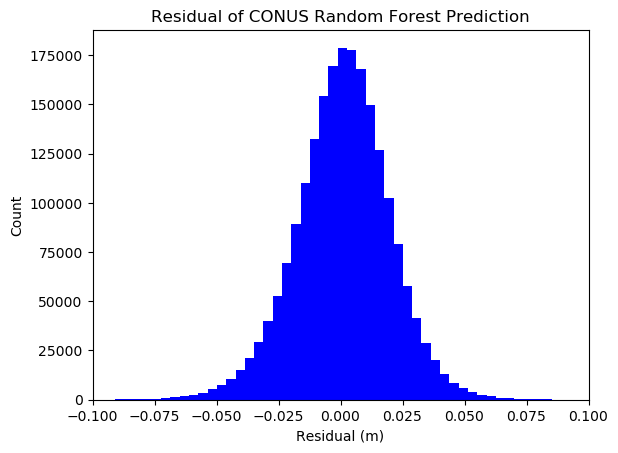

In [16]:
plt.hist(CONUS_rf_predict-CONUS_true, bins=450, color='blue')
plt.title('Residual of CONUS Random Forest Prediction')
plt.xlabel('Residual (m)')
plt.ylabel('Count')
plt.xlim(-0.1, 0.1)
# plt.text(-0.08, 150000, 'RMSE: {:.5f} m\n MAE: {:.5f} m \n MEAN: {:.5f} m'.format(rmse, MAE, np.mean(rf_predict-true) ), fontsize = 8, 
#          bbox = dict(facecolor = 'white', alpha = 0.5))
plt.show()

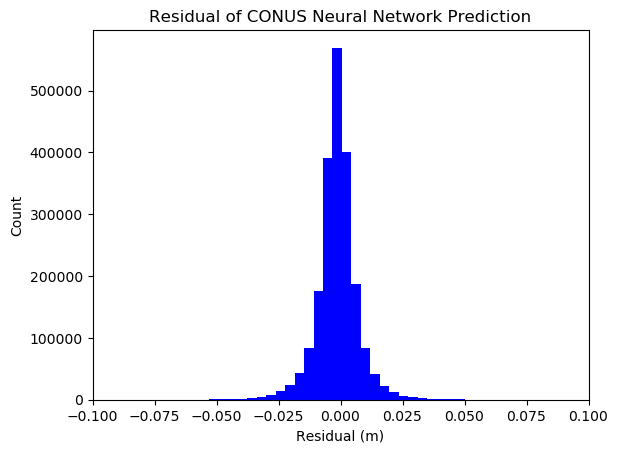

In [17]:
plt.hist(CONUS_nn_predict-CONUS_true, bins=450, color='blue')
plt.title('Residual of CONUS Neural Network Prediction')
plt.xlabel('Residual (m)')
plt.ylabel('Count')
plt.xlim(-0.1, 0.1)
# plt.text(-0.09, 400000, 'RMSE: {:.5f} m\n MAE: {:.5f} m \n MEAN: {:.5f} m'.format(0.00972, 0.00678, 0.00039 ), fontsize = 8, 
#          bbox = dict(facecolor = 'white', alpha = 0.5))
plt.show()

In [20]:
test_US['nn_model_prediction'] = CONUS_nn_predict
test_US['rf_model_prediction'] = CONUS_rf_predict

/tmp/ipykernel_18838/2309067766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_US['nn_model_prediction'] = CONUS_nn_predict
/tmp/ipykernel_18838/2309067766.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_US['rf_model_prediction'] = CONUS_rf_predict


In [22]:
test_US.head()

ID        Date  DOY     ZTD  wet_delay  hydrostatic_delay  times  \
5670625  OHLC  2021-01-01    1  2.3294     0.0413             2.2881  39600   
5670626  IABL  2021-01-01    1  2.3344     0.0885             2.2459  39600   
5670627  PSU3  2021-01-01    1  2.2815     0.0273             2.2542  39600   
5670628  NEGO  2021-01-01    1  2.1586     0.0475             2.1111  39600   
5670629  BCKW  2021-01-01    1  2.3241     0.1182             2.2059  39600   

         sigZTD      Lat       Lon  ...      e_44      e_45      e_46  \
5670625  0.0017  41.7212  -83.5263  ...  0.043976  0.037172  0.031665   
5670626  0.0017  40.7408  -92.4309  ...  0.044019  0.037242  0.031752   
5670627  0.0017  40.8069  -77.8498  ...  0.044112  0.037259  0.031738   
5670628  0.0018  40.9201 -100.1659  ...  0.041035  0.036228  0.031519   
5670629  0.0020  49.8848 -119.4954  ...  0.043086  0.036592  0.031350   

             e_47      e_48      e_49      e_50      e_51  \
5670625  0.026855  0.012074  0.005457  0.002980 -0.000133   
5670626  0.026955  0.012177  0.005506  0.002845 -0.000139   
5670627  0.026932  0.012123  0.005934  0.002881  0.000521   
5670628  0.026862  0.012212  0.005502  0.002824 -0.000043   
5670629  0.026782  0.012314  0.005808  0.002909  0.001319   

         nn_model_prediction  rf_model_prediction  
5670625             2.325704             2.327218  
5670626             2.324994             2.322520  
5670627             2.279577             2.281915  
5670628             2.154335             2.157977  
5670629             2.312625             2.311394  

[5 rows x 166 columns]

In [29]:
import glob
import xarray as xr
weather_file_path = '../GNSS_US/US/weather_model/weather_files/'
test_US['WM_ZTD'] = 0
dates_ = set(test_US.Date.values)
for i, date in enumerate(dates_):
    print(date)
    df = test_US[test_US['Date']==date]
    loc = np.hstack((df.Lon.values.reshape(-1,1), df.Lat.values.reshape(-1,1), df.Hgt_m.values.reshape(-1,1)))
    with xr.load_dataset(" ".join(glob.glob(weather_file_path + 'ERA-5_{date}_T11_00_00*[A-Z].nc'.format(date=date.replace('-', '_'))))) as wm:
        hydro_total_1_interp = make_interpretor(wm, 'hydro_total')
        wet_total_1_interp = make_interpretor(wm, 'wet_total')
  
    hydro1 = hydro_total_1_interp(loc)
    wet1 = wet_total_1_interp(loc)
    td1 = hydro1 + wet1
    test_US.loc[test_US.groupby('Date').get_group(date).index,'WM_ZTD'] = td1
    

/tmp/ipykernel_18838/1283248378.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_US['WM_ZTD'] = 0


2021-09-22
2021-01-02
2022-02-26
2021-08-09
2021-03-09
2022-04-15
2021-05-26
2021-11-02
2021-03-05
2022-01-13
2021-06-16
2022-01-08
2021-05-05
2022-02-04
2021-06-04
2021-11-01
2021-04-04
2022-01-07
2021-10-13
2022-01-05
2022-02-07
2021-08-20
2021-11-17
2022-02-21
2021-12-04
2021-05-22
2021-11-12
2021-03-01
2022-03-11
2021-01-06
2021-11-09
2021-10-15
2022-02-17
2021-03-26
2022-04-19
2021-06-09
2021-03-14
2021-05-03
2021-02-28
2021-10-27
2022-03-16
2022-04-28
2022-02-03
2021-04-17
2021-12-20
2021-11-03
2021-09-12
2021-04-20
2022-02-10
2021-03-27
2021-12-30
2021-05-04
2021-09-15
2021-04-01
2022-03-01
2021-06-25
2021-01-28
2021-11-11
2022-02-05
2022-02-28
2021-05-12
2021-05-06
2021-01-24
2021-02-09
2022-02-18
2022-01-28
2021-06-24
2021-07-25
2022-04-16
2021-06-15
2021-08-13
2021-09-10
2021-10-21
2021-07-19
2022-02-16
2021-06-11
2021-08-16
2021-08-24
2021-04-16
2021-02-08
2021-10-08
2022-01-22
2021-09-20
2021-06-05
2021-10-19
2021-08-05
2022-01-27
2021-11-16
2021-09-01
2022-01-24
2021-11-28

In [31]:
test_US.to_csv('../GNSS_US/test_CONUS_PTE_vert_fixed_hgtlvs_with_pred.csv',index=False)

In [32]:
test_US.head()

ID        Date  DOY     ZTD  wet_delay  hydrostatic_delay  times  \
5670625  OHLC  2021-01-01    1  2.3294     0.0413             2.2881  39600   
5670626  IABL  2021-01-01    1  2.3344     0.0885             2.2459  39600   
5670627  PSU3  2021-01-01    1  2.2815     0.0273             2.2542  39600   
5670628  NEGO  2021-01-01    1  2.1586     0.0475             2.1111  39600   
5670629  BCKW  2021-01-01    1  2.3241     0.1182             2.2059  39600   

         sigZTD      Lat       Lon  ...      e_45      e_46      e_47  \
5670625  0.0017  41.7212  -83.5263  ...  0.037172  0.031665  0.026855   
5670626  0.0017  40.7408  -92.4309  ...  0.037242  0.031752  0.026955   
5670627  0.0017  40.8069  -77.8498  ...  0.037259  0.031738  0.026932   
5670628  0.0018  40.9201 -100.1659  ...  0.036228  0.031519  0.026862   
5670629  0.0020  49.8848 -119.4954  ...  0.036592  0.031350  0.026782   

             e_48      e_49      e_50      e_51  nn_model_prediction  \
5670625  0.012074  0.005457  0.002980 -0.000133             2.325704   
5670626  0.012177  0.005506  0.002845 -0.000139             2.324994   
5670627  0.012123  0.005934  0.002881  0.000521             2.279577   
5670628  0.012212  0.005502  0.002824 -0.000043             2.154335   
5670629  0.012314  0.005808  0.002909  0.001319             2.312625   

         rf_model_prediction    WM_ZTD  
5670625             2.327218  2.345241  
5670626             2.322520  2.343962  
5670627             2.281915  2.298813  
5670628             2.157977  2.167268  
5670629             2.311394  2.327324  

[5 rows x 167 columns]

In [34]:
error_by_station = test_US.groupby('ID').mean()[['Lat', 'Lon', 'Hgt_m', 'ZTD', 'nn_model_prediction', 'rf_model_prediction', 'WM_ZTD']]

/tmp/ipykernel_18838/3566216616.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  error_by_station = test_US.groupby('ID').mean()[['Lat', 'Lon', 'Hgt_m', 'ZTD', 'nn_model_prediction', 'rf_model_prediction', 'WM_ZTD']]


In [33]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

def rmse(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['nn_model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse_(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['rf_model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse__(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['WM_ZTD']))
    return pd.Series(dict(rmse = rmse))

In [62]:
error_by_station['nn_Avg_error'] = (test_US.nn_model_prediction-test_US.ZTD).groupby(test_US['ID']).mean()
error_by_station['nn_RMSE'] = test_US.groupby('ID').apply(rmse)['rmse']
error_by_station['rf_Avg_error'] = (test_US.rf_model_prediction-test_US.ZTD).groupby(test_US['ID']).mean()
error_by_station['rf_RMSE'] = test_US.groupby('ID').apply(rmse_)['rmse']
error_by_station['wm_Avg_error'] = (test_US.WM_ZTD-test_US.ZTD).groupby(test_US['ID']).mean()
error_by_station['wm_RMSE'] = test_US.groupby('ID').apply(rmse__)['rmse']

In [63]:
error_by_station.head()

Lat      Lon   Hgt_m       ZTD  nn_model_prediction  \
ID                                                              
14PT  45.4001 -75.9194  45.265  2.339500             2.342155   
14ST  45.4001 -75.9194  45.263  2.366500             2.361472   
14T1  45.4001 -75.9194  45.260  2.356767             2.359048   
1LSU  30.4074 -91.1803  -6.487  2.488099             2.479180   
1NSU  31.7508 -93.0976  28.071  2.468683             2.465092   

      rf_model_prediction    WM_ZTD  nn_Avg_error   nn_RMSE  rf_Avg_error  \
ID                                                                          
14PT             2.347051  2.354981      0.002655  0.002655      0.007551   
14ST             2.347051  2.377381     -0.005028  0.005028     -0.019449   
14T1             2.366435  2.374479      0.002281  0.003324      0.009668   
1LSU             2.478497  2.502542     -0.008920  0.013960     -0.009602   
1NSU             2.469558  2.486606     -0.003591  0.012062      0.000875   

       rf_RMSE  wm_Avg_error   wm_RMSE  
ID                                      
14PT  0.007551      0.015481  0.015481  
14ST  0.019449      0.010881  0.010881  
14T1  0.024815      0.017712  0.017880  
1LSU  0.022993      0.014443  0.018576  
1NSU  0.021209      0.017923  0.021864

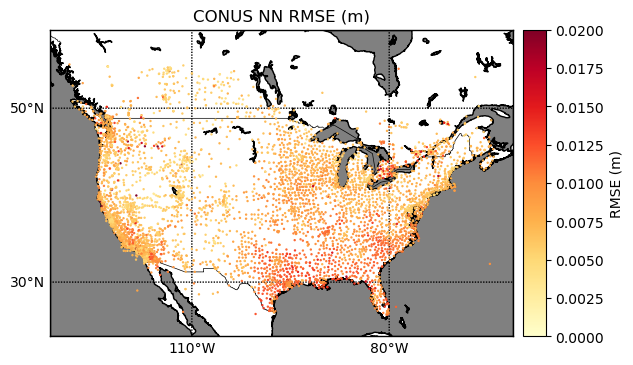

In [43]:
# day1 = day1[(day1['Lat'] >30) & (day1['Lat'] < 60) & ((day1['Lon'] > -120) & (day1['Lon'] < -60))]
lat = error_by_station['Lat']
lon = error_by_station['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 3 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=0,
            lon_0=0,
            projection='merc',
            resolution = 'i',
            area_thresh=1000
            )
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(-90,90,20)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True])
meridians = np.arange(10.,351.,30)
m.drawmeridians(meridians,labels=[True,False,False,True])
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = '.', c=error_by_station['nn_RMSE'], cmap='YlOrRd', s=2, zorder=5, vmin=0, vmax=0.02)
m.colorbar(label='RMSE (m)')
plt.title('CONUS NN RMSE (m)')
plt.savefig('Plots/CONUS_NN_RMSE.png', dpi=250)
plt.show()

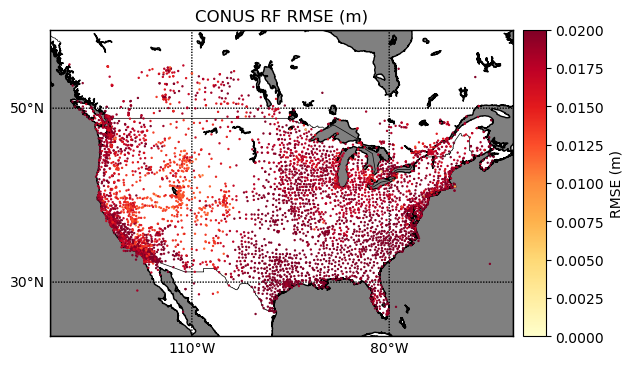

In [44]:
# day1 = day1[(day1['Lat'] >30) & (day1['Lat'] < 60) & ((day1['Lon'] > -120) & (day1['Lon'] < -60))]
lat = error_by_station['Lat']
lon = error_by_station['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 3 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=0,
            lon_0=0,
            projection='merc',
            resolution = 'i',
            area_thresh=1000
            )
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(-90,90,20)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True])
meridians = np.arange(10.,351.,30)
m.drawmeridians(meridians,labels=[True,False,False,True])
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = '.', c=error_by_station['rf_RMSE'], cmap='YlOrRd', s=2, zorder=5, vmin=0, vmax=0.02)
m.colorbar(label='RMSE (m)')
plt.title('CONUS RF RMSE (m)')
plt.savefig('Plots/CONUS_RF_RMSE.png', dpi=250)
plt.show()

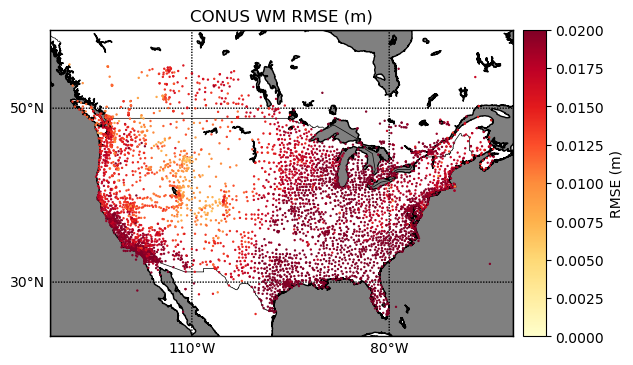

In [45]:
# day1 = day1[(day1['Lat'] >30) & (day1['Lat'] < 60) & ((day1['Lon'] > -120) & (day1['Lon'] < -60))]
lat = error_by_station['Lat']
lon = error_by_station['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 3 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=0,
            lon_0=0,
            projection='merc',
            resolution = 'i',
            area_thresh=1000
            )
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(-90,90,20)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True])
meridians = np.arange(10.,351.,30)
m.drawmeridians(meridians,labels=[True,False,False,True])
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = '.', c=error_by_station['wm_RMSE'], cmap='YlOrRd', s=2, zorder=5, vmin=0, vmax=0.02)
m.colorbar(label='RMSE (m)')
plt.title('CONUS WM RMSE (m)')
plt.savefig('Plots/CONUS_WM_RMSE.png', dpi=250)
plt.show()

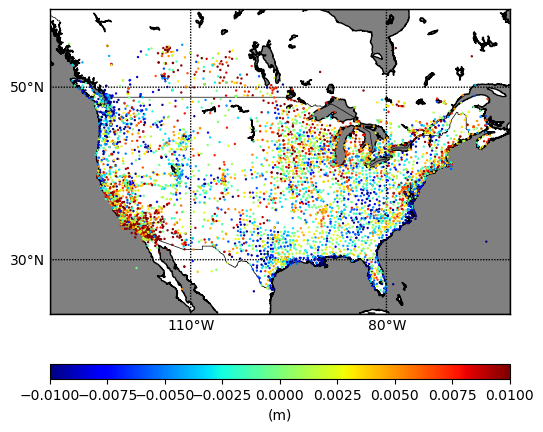

In [64]:
# day1 = day1[(day1['Lat'] >30) & (day1['Lat'] < 60) & ((day1['Lon'] > -120) & (day1['Lon'] < -60))]
lat = error_by_station['Lat']
lon = error_by_station['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 3 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=0,
            lon_0=0,
            projection='merc',
            resolution = 'i',
            area_thresh=1000
            )
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(-90,90,20)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True])
meridians = np.arange(10.,351.,30)
m.drawmeridians(meridians,labels=[True,False,False,True])
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = '.', c=error_by_station['rf_Avg_error'], cmap='jet', s=2, zorder=5, vmin=-0.01, vmax=0.01)
m.colorbar(label='(m)', pad= 0.5, location='bottom')
# plt.title('CONUS WM RMSE (m)')
# plt.savefig('Plots/CONUS_WM_RMSE.png', dpi=250)
plt.show()

<Figure size 640x480 with 0 Axes>

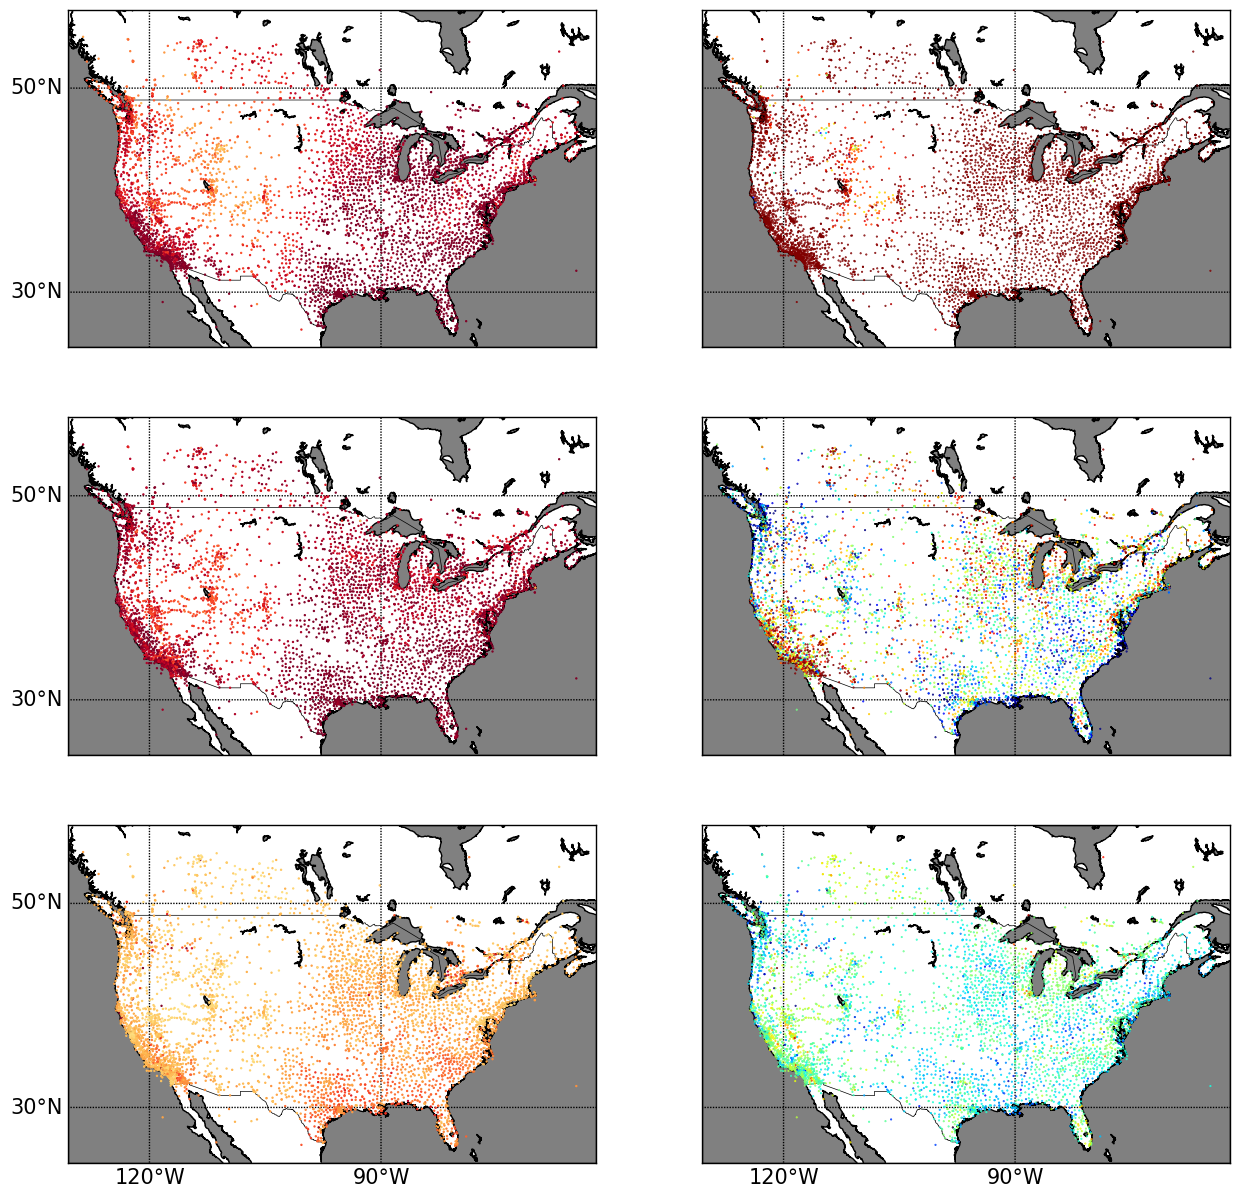

In [ ]:
lat = error_by_station['Lat']
lon = error_by_station['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 2 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin
plt.clf()
fig, axes = plt.subplots(3,2, figsize=(15,15))

# axes[0,0].set_title('WM_RMSE')
m = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[0,0])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
parallels = np.arange(-90,90,20)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,False], fontsize=15)
meridians = np.arange(0,360.,30)
m.drawmeridians(meridians,labels=[True,False,False,False], fontsize=15)
lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['wm_RMSE'], cmap='YlOrRd', s=2, zorder=5, vmin=0, vmax=0.02)

m = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[1,0])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,False], fontsize=15)
# meridians = np.arange(0,360.,60)
m.drawmeridians(meridians,labels=[True,False,False,False], fontsize=15)
lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['rf_RMSE'], cmap='YlOrRd', s=2, zorder=5, vmin=0, vmax=0.02)

m = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[2,0])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], fontsize=15)
# meridians = np.arange(0,360.,60)
m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=15)
lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['nn_RMSE'], cmap='YlOrRd', s=2, zorder=5, vmin=0, vmax=0.02)

m = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[0,1])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False], fontsize=15)
# meridians = np.arange(0,360.,60)
m.drawmeridians(meridians,labels=[False,False,False,False], fontsize=15)
lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['wm_Avg_error'], cmap='jet', s=1, zorder=5, vmin=-0.01, vmax=0.01)

m = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[1,1])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False], fontsize=15)
# meridians = np.arange(0,360.,60)
m.drawmeridians(meridians,labels=[False,False,False,False], fontsize=15)
lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['rf_Avg_error'], cmap='jet', s=1, zorder=5, vmin=-0.01, vmax=0.01)

m = Basemap(llcrnrlon=lon_min,llcrnrlat=lat_min,urcrnrlon=lon_max,urcrnrlat=lat_max,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[2,1])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,True], fontsize=15)
# meridians = np.arange(0,360.,60)
m.drawmeridians(meridians,labels=[False,False,False,True], fontsize=15)
lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['nn_Avg_error'], cmap='jet', s=1, zorder=5, vmin=-0.01, vmax=0.01)

plt.show()

## Residual with time

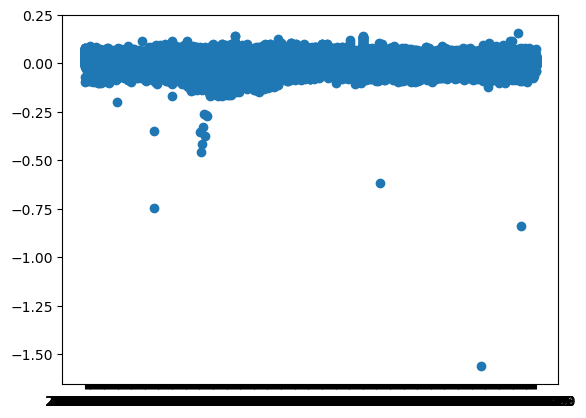

In [136]:
plt.scatter(test_US.Date, test_US.WM_ZTD- test_US.ZTD)
plt.show()

# Model Performance for Global Data

In [119]:
new_test = pd.read_csv('../GNSS/Global_dat/Full_Global_data/test_global_PTE_vert_fixed_hgtlvs_with_pred.csv')

In [7]:
from joblib import dump, load
import tensorflow as tf
rf_model = load('Model/Global_PTE_fixed_hgtlvs_RF.joblib') # This take a very long time to load because of it's 16 GB
nn_model = tf.keras.models.load_model('Model/global_PTE_fixed_hgtlvs_02_20_model')
scaler_x = load('Scaler/global_MinMax_scaler_x.bin')

2023-04-16 00:42:26.328860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/nyv62/miniconda3/envs/RAiDER/lib/python3.10/site-packages/sklearn/base.py:288: UserWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.2.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [121]:
new_test.head()

Unnamed: 0    ID        Date     ZTD  wet_delay  hydrostatic_delay  times  \
0     1082502  D143  2021-01-10  2.2784     0.0470             2.2314      0   
1     1082503  OHLC  2021-01-10  2.3306     0.0446             2.2860      0   
2     1082504  TGRI  2021-01-10  2.2803     0.1029             2.1774      0   
3     1082505  X059  2021-01-10  2.3109     0.0165             2.2944      0   
4     1082506  IABL  2021-01-10  2.3108     0.0415             2.2693      0   

   sigZTD      Lat       Lon  ...      e_45      e_46      e_47      e_48  \
0  0.0026  50.7323   12.5203  ...  0.032060  0.027417  0.023558  0.012157   
1  0.0026  41.7212  -83.5263  ...  0.033288  0.029017  0.025795  0.012191   
2  0.0034 -38.9771  175.8585  ...  0.029205  0.023876  0.021358  0.012107   
3  0.0037  34.8012  138.0731  ...  0.033044  0.028310  0.024358  0.012449   
4  0.0027  40.7408  -92.4309  ...  0.033409  0.028564  0.024460  0.011663   

       e_49      e_50      e_51  rf_Model_prediction  nn_model_prediction  \
0  0.006304  0.002424 -0.001055             2.267286             2.267729   
1  0.006212  0.002963  0.001417             2.342560             2.345321   
2  0.006411  0.003133  0.000815             2.287976             2.286639   
3  0.006126  0.003159  0.000666             2.322539             2.317984   
4  0.006376  0.003002  0.001422             2.317579             2.310547   

     WM_ZTD  
0  2.273620  
1  2.355923  
2  2.301905  
3  2.325357  
4  2.335052  

[5 rows x 167 columns]

In [122]:
# error_by_station = new_test.groupby('Month',as_index=False).mean()[['Month', 'Lat', 'Lon', 'Hgt_m', 'ZTD', 'nn_model_prediction', 'rf_Model_prediction', 'WM_ZTD']]
error_by_station = new_test.groupby('ID').mean()[['Lat', 'Lon', 'Hgt_m', 'ZTD', 'nn_model_prediction', 'rf_Model_prediction', 'WM_ZTD']]
error_by_station.head()

/tmp/ipykernel_18838/2304268470.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  error_by_station = new_test.groupby('ID').mean()[['Lat', 'Lon', 'Hgt_m', 'ZTD', 'nn_model_prediction', 'rf_Model_prediction', 'WM_ZTD']]


Lat      Lon    Hgt_m       ZTD  nn_model_prediction  \
ID                                                               
0ABI  68.3543  18.8164  431.388  2.240380             2.236751   
0ABY  58.6589  16.1796   60.548  2.384332             2.379727   
0AKE  59.4814  18.3020   43.131  2.384377             2.380810   
0ALE  62.7805  16.0137  272.454  2.304998             2.301515   
0ALF  61.3445  16.0649  142.743  2.349534             2.345494   

      rf_Model_prediction    WM_ZTD  
ID                                   
0ABI             2.238568  2.249014  
0ABY             2.383474  2.388727  
0AKE             2.381322  2.389516  
0ALE             2.302740  2.311721  
0ALF             2.349247  2.354788

In [124]:
from sklearn.metrics import r2_score, mean_squared_error

def rmse(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['nn_model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse_(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['rf_Model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse__(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['WM_ZTD']))
    return pd.Series(dict(rmse = rmse))

In [125]:
error_by_station['nn_Avg_error'] = (new_test.nn_model_prediction-new_test.ZTD).groupby(new_test['ID']).mean()
error_by_station['nn_RMSE'] = new_test.groupby('ID').apply(rmse)['rmse']
error_by_station['rf_Avg_error'] = (new_test.rf_Model_prediction-new_test.ZTD).groupby(new_test['ID']).mean()
error_by_station['rf_RMSE'] = new_test.groupby('ID').apply(rmse_)['rmse']
error_by_station['wm_Avg_error'] = (new_test.WM_ZTD-new_test.ZTD).groupby(new_test['ID']).mean()
error_by_station['wm_RMSE'] = new_test.groupby('ID').apply(rmse__)['rmse']

In [19]:
error_by_station.head()

Lat      Lon    Hgt_m       ZTD  nn_model_prediction  \
ID                                                               
0ABI  68.3543  18.8164  431.388  2.240380             2.236751   
0ABY  58.6589  16.1796   60.548  2.384332             2.379727   
0AKE  59.4814  18.3020   43.131  2.384377             2.380810   
0ALE  62.7805  16.0137  272.454  2.304998             2.301515   
0ALF  61.3445  16.0649  142.743  2.349534             2.345494   

      rf_Model_prediction    WM_ZTD  nn_Avg_error   nn_RMSE  rf_Avg_error  \
ID                                                                          
0ABI             2.238568  2.249014     -0.003628  0.007216     -0.001811   
0ABY             2.383474  2.388727     -0.004605  0.008966     -0.000858   
0AKE             2.381322  2.389516     -0.003568  0.011536     -0.003056   
0ALE             2.302740  2.311721     -0.003482  0.008105     -0.002257   
0ALF             2.349247  2.354788     -0.004040  0.006754     -0.000287   

       rf_RMSE  wm_Avg_error   wm_RMSE  
ID                                      
0ABI  0.007411      0.008635  0.010152  
0ABY  0.007675      0.004395  0.007984  
0AKE  0.010372      0.005139  0.011752  
0ALE  0.008374      0.006723  0.009896  
0ALF  0.007486      0.005254  0.007735

<Figure size 640x480 with 0 Axes>

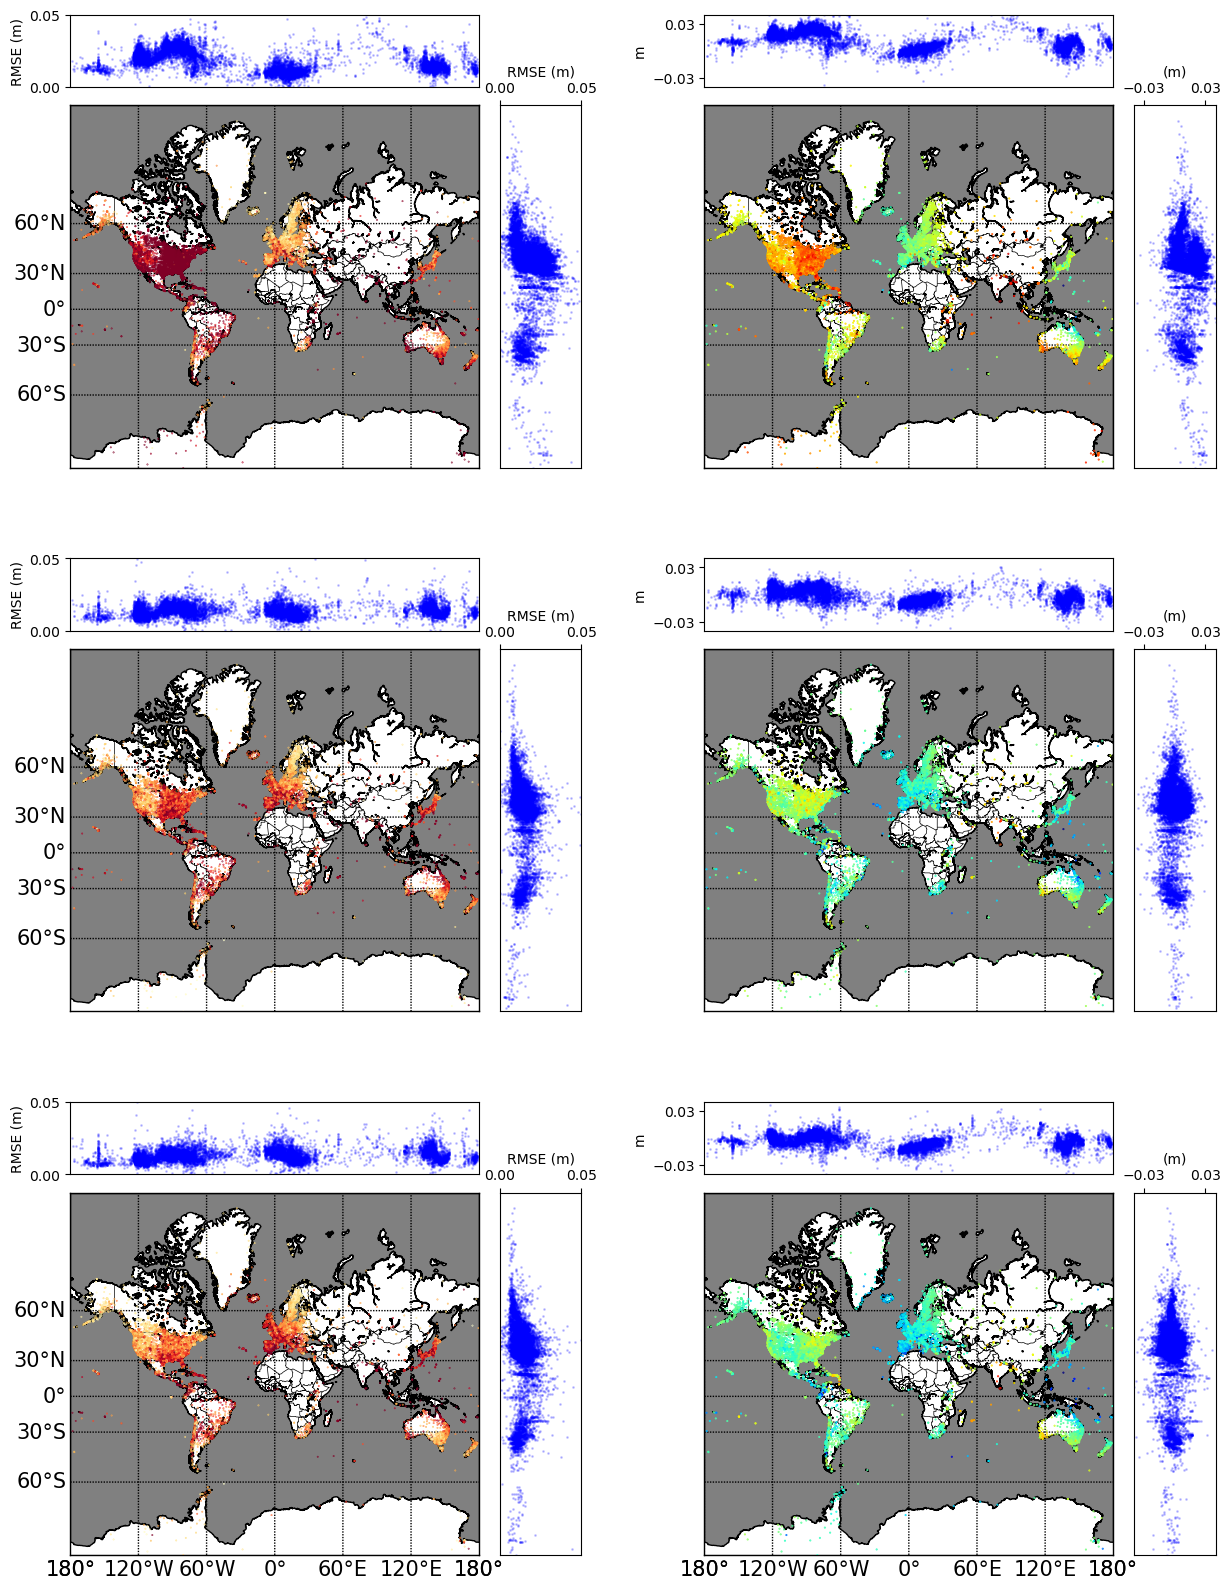

In [74]:
lat = error_by_station['Lat']
lon = error_by_station['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 0 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin
plt.clf()
fig, axes = plt.subplots(3,2, figsize=(15,20))

# axes[0,0].set_title('WM_RMSE')
m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[0,0])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,False], fontsize=15)
meridians = np.arange(0,360.,60)
m.drawmeridians(meridians,labels=[True,False,False,False], fontsize=15)
lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['wm_RMSE'], cmap='YlOrRd', s=0.5, zorder=5, vmin=0.005, vmax=0.02)
divider = make_axes_locatable(axes[0,0])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[0,0])
x_plot = divider.append_axes('top', size='20%', pad='5%', sharex=axes[0,0])
stat_lon, stat_lat = m(error_by_station.Lon, error_by_station.Lat)
## histogram on the attached axes
y_hist.scatter(error_by_station.wm_RMSE,stat_lat, color='blue',s=1, alpha=0.2)
# y_hist.invert_xaxis()
y_hist.set_xlabel('RMSE (m)')
y_hist.set_xlim(0, 0.05)
y_hist.set_xticks([0,0.05])
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 
x_plot.scatter(stat_lon, error_by_station.wm_RMSE, color='blue',s=1, alpha=0.2)
x_plot.set_ylabel('RMSE (m)')
x_plot.set_ylim(0, 0.05)
x_plot.set_yticks([0,0.05])
x_plot.yaxis.set_tick_params(labelsize=10)


# axes[1,0].set_title('RF_RMSE')
m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[1,0])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,False], fontsize=15)
# meridians = np.arange(0,360.,60)
m.drawmeridians(meridians,labels=[True,False,False,False], fontsize=15)
# lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['rf_RMSE'], cmap='YlOrRd', s=0.5, zorder=5, vmin=0.005, vmax=0.02)
divider = make_axes_locatable(axes[1,0])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[1,0])
x_plot = divider.append_axes('top', size='20%', pad='5%', sharex=axes[1,0])
stat_lon, stat_lat = m(error_by_station.Lon, error_by_station.Lat)
## histogram on the attached axes
y_hist.scatter(error_by_station.rf_RMSE,stat_lat, color='blue',s=1, alpha=0.2)
# y_hist.invert_xaxis()
y_hist.set_xlabel('RMSE (m)')
y_hist.set_xlim(0, 0.05)
y_hist.set_xticks([0,0.05])
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 
x_plot.scatter(stat_lon, error_by_station.rf_RMSE, color='blue',s=1, alpha=0.2)
x_plot.set_ylabel('RMSE (m)')
x_plot.set_ylim(0, 0.05)
x_plot.set_yticks([0,0.05])
x_plot.yaxis.set_tick_params(labelsize=10)


# axes[2,0].set_title('NN_RMSE')
m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[2,0])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True], fontsize=15)
# meridians = np.arange(0.,351.,50)
m.drawmeridians(meridians,labels=[True,False,False,True], fontsize=15)
# lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['nn_RMSE'], cmap='YlOrRd', s=0.5, zorder=5, vmin=0.005, vmax=0.02)
divider = make_axes_locatable(axes[2,0])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[2,0])
x_plot = divider.append_axes('top', size='20%', pad='5%', sharex=axes[2,0])
stat_lon, stat_lat = m(error_by_station.Lon, error_by_station.Lat)
## histogram on the attached axes
y_hist.scatter(error_by_station.nn_RMSE,stat_lat, color='blue',s=1, alpha=0.2)
# y_hist.invert_xaxis()
y_hist.set_xlabel('RMSE (m)')
y_hist.set_xlim(0, 0.05)
y_hist.set_xticks([0,0.05])
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 
x_plot.scatter(stat_lon, error_by_station.nn_RMSE, color='blue',s=1, alpha=0.2)
x_plot.set_ylabel('RMSE (m)')
x_plot.set_ylim(0, 0.05)
x_plot.set_yticks([0,0.05])
x_plot.yaxis.set_tick_params(labelsize=10)


# axes[0,1].set_title('WM_Avg_Error')
m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[0,1])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False])
# meridians = np.arange(0.,351.,50)
m.drawmeridians(meridians,labels=[False,False,False,False])
# lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['wm_Avg_error'], cmap='jet', s=1, zorder=5, vmin=-0.04, vmax=0.04)
divider = make_axes_locatable(axes[0,1])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[0,1])
x_plot = divider.append_axes('top', size='20%', pad='5%', sharex=axes[0,1])
stat_lon, stat_lat = m(error_by_station.Lon, error_by_station.Lat)
## histogram on the attached axes
y_hist.scatter(error_by_station.wm_Avg_error,stat_lat, color='blue',s=1, alpha=0.2,)
# y_hist.invert_xaxis()
y_hist.set_xlabel('(m)')
y_hist.set_xlim(-0.04, 0.04)
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.set_xticks([-0.03, 0.03])
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 
x_plot.scatter(stat_lon, error_by_station.wm_Avg_error, color='blue',s=1, alpha=0.2)
x_plot.set_ylabel('m')
x_plot.set_ylim(-0.04, 0.04)
x_plot.set_yticks([-0.03, 0.03])
x_plot.yaxis.set_tick_params(labelsize=10)


# axes[1,1].set_title('RF_Avg_Error')
m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[1,1])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,False])
# meridians = np.arange(0.,351.,50)
m.drawmeridians(meridians,labels=[False,False,False,False])
# lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['rf_Avg_error'], cmap='jet', s=1, zorder=5, vmin=-0.04, vmax=0.04)
divider = make_axes_locatable(axes[1,1])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[1,1])
x_plot = divider.append_axes('top', size='20%', pad='5%', sharex=axes[1,1])
stat_lon, stat_lat = m(error_by_station.Lon, error_by_station.Lat)
## histogram on the attached axes
y_hist.scatter(error_by_station.rf_Avg_error,stat_lat, color='blue',s=1, alpha=0.2,)
# y_hist.invert_xaxis()
y_hist.set_xlabel('(m)')
y_hist.set_xlim(-0.04, 0.04)
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.set_xticks([-0.03, 0.03])
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 
x_plot.scatter(stat_lon, error_by_station.rf_Avg_error, color='blue',s=1, alpha=0.2)
x_plot.set_ylabel('m')
x_plot.set_ylim(-0.04, 0.04)
x_plot.set_yticks([-0.03, 0.03])
x_plot.yaxis.set_tick_params(labelsize=10)

# axes[2,1].set_title('NN_Avg_Error')
m = Basemap(llcrnrlon=-180,llcrnrlat=-80,urcrnrlon=180,urcrnrlat=85,lat_0=0,lon_0=0,projection='merc',
            resolution = 'i',area_thresh=1000, ax=axes[2,1])
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# parallels = np.arange(-90,90,30)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,False,True], fontsize=15)
# meridians = np.arange(0.,351.,50)
m.drawmeridians(meridians,labels=[False,False,False,True], fontsize=15)
# lons, lats = m(lon, lat)
# plot points as red dots
a = m.scatter(lons, lats, marker = '.', c=error_by_station['nn_Avg_error'], cmap='jet', s=1, zorder=5, vmin=-0.04, vmax=0.04)
divider = make_axes_locatable(axes[2,1])
y_hist = divider.append_axes('right', size='20%', pad='5%', sharey=axes[2,1])
x_plot = divider.append_axes('top', size='20%', pad='5%', sharex=axes[2,1])
stat_lon, stat_lat = m(error_by_station.Lon, error_by_station.Lat)
## histogram on the attached axes
y_hist.scatter(error_by_station.nn_Avg_error,stat_lat, color='blue',s=1, alpha=0.2,)
# y_hist.invert_xaxis()
y_hist.set_xlabel('(m)')
y_hist.set_xlim(-0.04, 0.04)
y_hist.xaxis.set_tick_params(labelsize=10)
y_hist.set_xticks([-0.03, 0.03])
y_hist.xaxis.tick_top()
y_hist.xaxis.set_label_position('top') 
x_plot.scatter(stat_lon, error_by_station.nn_Avg_error, color='blue',s=1, alpha=0.2)
x_plot.set_ylabel('m')
x_plot.set_ylim(-0.04, 0.04)
x_plot.set_yticks([-0.03, 0.03])
x_plot.yaxis.set_tick_params(labelsize=10)

fig.savefig('Plots/Global_model_performance.png', dpi=600)
plt.show()

In [57]:
print("NN model")
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(new_test.ZTD, new_test.nn_model_prediction))
print('Mean: %.5f' % np.mean(new_test.nn_model_prediction-new_test.ZTD))

# The R2 score
print('R2: %.5f' % r2_score(new_test.ZTD, new_test.nn_model_prediction))

# The RMSE
rmse = np.sqrt(mean_squared_error(new_test.ZTD, new_test.nn_model_prediction))
print('RMSE: %.5f' % rmse)

errors = new_test.nn_model_prediction - new_test.ZTD
MAE = np.mean(abs(errors))
print('MAE: %.5f' % MAE )

NN model
Mean squared error: 0.0001956754
Mean: -0.00288
R2: 0.99381
RMSE: 0.01399
MAE: 0.01034


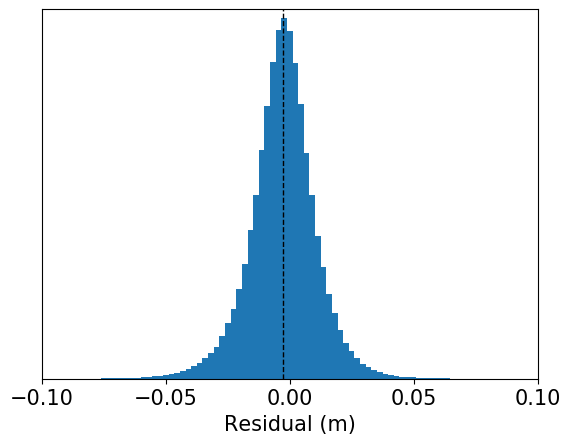

In [68]:
plt.hist(new_test.nn_model_prediction - new_test.ZTD, bins=250)
# plt.ylabel('Frequency')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) 
plt.xlim(-0.1, 0.1)
plt.xlabel('Residual (m)', fontsize=15)
plt.xticks([-0.1,-0.05, 0 , 0.05, 0.1],fontsize=15)
plt.ylim(0, 39000)
plt.axvline((new_test.nn_model_prediction - new_test.ZTD).mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Plots/NN_residual_plot.png', dpi=250)
plt.show()

In [69]:
print("RF model")
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(new_test.ZTD, new_test.rf_Model_prediction))
print('Mean: %.5f' % np.mean(new_test.rf_Model_prediction-new_test.ZTD))

# The R2 score
print('R2: %.5f' % r2_score(new_test.ZTD, new_test.rf_Model_prediction))

# The RMSE
rmse = np.sqrt(mean_squared_error(new_test.ZTD, new_test.rf_Model_prediction))
print('RMSE: %.5f' % rmse)

errors = new_test.rf_Model_prediction - new_test.ZTD
MAE = np.mean(abs(errors))
print('MAE: %.5f' % MAE )

RF model
Mean squared error: 0.0002184888
Mean: -0.00024
R2: 0.99309
RMSE: 0.01478
MAE: 0.01107


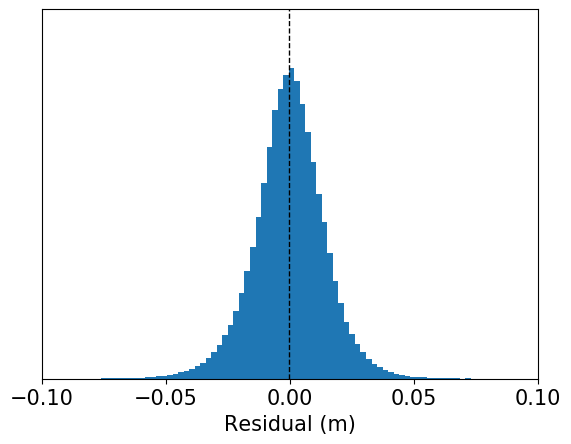

In [70]:
plt.hist(new_test.rf_Model_prediction - new_test.ZTD, bins=250)
plt.xlim(-0.1, 0.1)
plt.ylim(0, 39000)
# plt.ylabel('Frequency')
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) 
plt.xlabel('Residual (m)', fontsize=15)
plt.xticks([-0.1,-0.05, 0 , 0.05, 0.1],fontsize=15)
plt.axvline((new_test.rf_Model_prediction - new_test.ZTD).mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Plots/RF_residual_plot.png', dpi=250)
plt.show()

In [71]:
print("WM model")
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(new_test.ZTD, new_test.WM_ZTD))
print('Mean: %.5f' % np.mean(new_test.WM_ZTD-new_test.ZTD))

# The R2 score
print('R2: %.5f' % r2_score(new_test.ZTD, new_test.WM_ZTD))

# The RMSE
rmse = np.sqrt(mean_squared_error(new_test.ZTD, new_test.WM_ZTD))
print('RMSE: %.5f' % rmse)

errors = new_test.WM_ZTD - new_test.ZTD
MAE = np.mean(abs(errors))
print('MAE: %.5f' % MAE )

WM model
Mean squared error: 0.0004067769
Mean: 0.01301
R2: 0.98713
RMSE: 0.02017
MAE: 0.01614


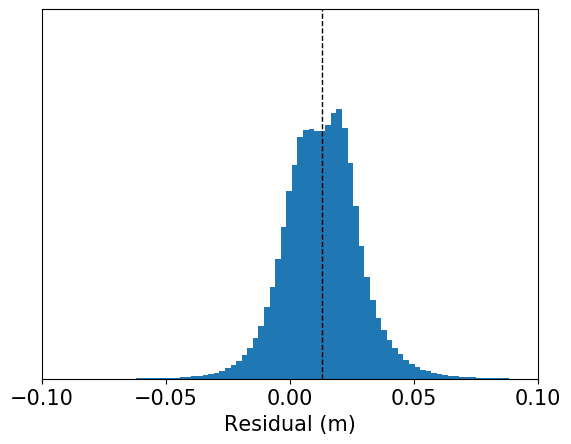

In [72]:
plt.hist(new_test.WM_ZTD - new_test.ZTD, bins=250)
plt.xlim(-0.1, 0.1)
plt.ylim(0, 39000)
# plt.ylabel('Frequency')
plt.xlabel('Residual (m)', fontsize=15)
plt.xticks([-0.1,-0.05, 0 , 0.05, 0.1],fontsize=15)
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
plt.axvline((new_test.WM_ZTD - new_test.ZTD).mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Plots/WM_residual_plot.png', dpi=250)
plt.show()

## Residual vs Elevation dependency

In [126]:
new_test

Unnamed: 0    ID        Date     ZTD  wet_delay  hydrostatic_delay  \
0          1082502  D143  2021-01-10  2.2784     0.0470             2.2314   
1          1082503  OHLC  2021-01-10  2.3306     0.0446             2.2860   
2          1082504  TGRI  2021-01-10  2.2803     0.1029             2.1774   
3          1082505  X059  2021-01-10  2.3109     0.0165             2.2944   
4          1082506  IABL  2021-01-10  2.3108     0.0415             2.2693   
...            ...   ...         ...     ...        ...                ...   
457475     1539977  J782  2022-10-17  2.3381     0.1235             2.2146   
457476     1539978  P080  2022-10-17  1.8765     0.0447             1.8318   
457477     1539979  GACE  2022-10-17  2.3348     0.1518             2.1830   
457478     1539980  TGBS  2022-10-17  2.4852     0.1728             2.3124   
457479     1539981  P397  2022-10-17  2.2313     0.0741             2.1572   

        times  sigZTD      Lat       Lon  ...      e_45      e_46      e_47  \
0           0  0.0026  50.7323   12.5203  ...  0.032060  0.027417  0.023558   
1           0  0.0026  41.7212  -83.5263  ...  0.033288  0.029017  0.025795   
2           0  0.0034 -38.9771  175.8585  ...  0.029205  0.023876  0.021358   
3           0  0.0037  34.8012  138.0731  ...  0.033044  0.028310  0.024358   
4           0  0.0027  40.7408  -92.4309  ...  0.033409  0.028564  0.024460   
...       ...     ...      ...       ...  ...       ...       ...       ...   
457475      0  0.0025  44.3651  142.2645  ...  0.039768  0.032811  0.027906   
457476      0  0.0023  39.1194 -114.2772  ...  0.043733  0.036500  0.029793   
457477      0  0.0027  34.5114  -83.5237  ...  0.041998  0.034082  0.028726   
457478      0  0.0026  53.5769    6.6614  ...  0.039257  0.032777  0.027944   
457479      0  0.0023  46.4216 -123.7992  ...  0.041095  0.034114  0.028796   

            e_48      e_49      e_50      e_51  rf_Model_prediction  \
0       0.012157  0.006304  0.002424 -0.001055             2.267286   
1       0.012191  0.006212  0.002963  0.001417             2.342560   
2       0.012107  0.006411  0.003133  0.000815             2.287976   
3       0.012449  0.006126  0.003159  0.000666             2.322539   
4       0.011663  0.006376  0.003002  0.001422             2.317579   
...          ...       ...       ...       ...                  ...   
457475  0.012748  0.006563  0.003218  0.001391             2.323491   
457476  0.012942  0.006629  0.003261  0.001381             1.872529   
457477  0.012957  0.006263  0.002832  0.001022             2.354305   
457478  0.013185  0.006485  0.003055  0.001409             2.459804   
457479  0.013295  0.006877  0.003150  0.001446             2.233227   

        nn_model_prediction    WM_ZTD  
0                  2.267729  2.273620  
1                  2.345321  2.355923  
2                  2.286639  2.301905  
3                  2.317984  2.325357  
4                  2.310547  2.335052  
...                     ...       ...  
457475             2.321986  2.341024  
457476             1.871174  1.891669  
457477             2.348444  2.367171  
457478             2.467183  2.470469  
457479             2.243631  2.254035  

[457480 rows x 167 columns]

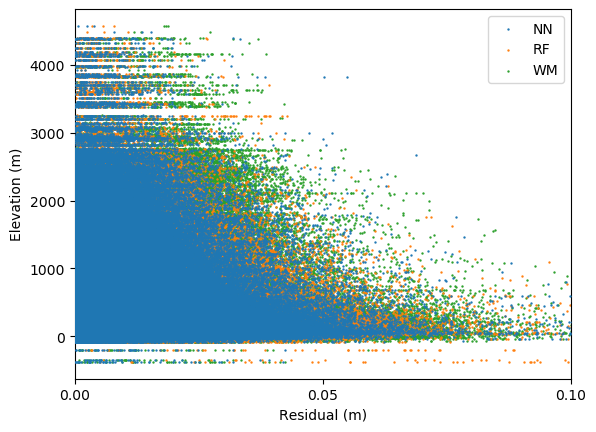

In [169]:
plt.scatter(np.abs(new_test.nn_model_prediction- new_test.ZTD), new_test.Hgt_m, s=0.5, zorder=3, label='NN')
plt.scatter(np.abs(new_test.rf_Model_prediction- new_test.ZTD), new_test.Hgt_m, s=0.5, zorder=2, label='RF')
plt.scatter(np.abs(new_test.WM_ZTD - new_test.ZTD), new_test.Hgt_m, s=0.5,  zorder=1,label='WM')
plt.xlim(0, 0.1)
plt.xticks([0, 0.05, 0.1])
plt.legend()
plt.xlabel('Residual (m)')
plt.ylabel('Elevation (m)')
plt.show()

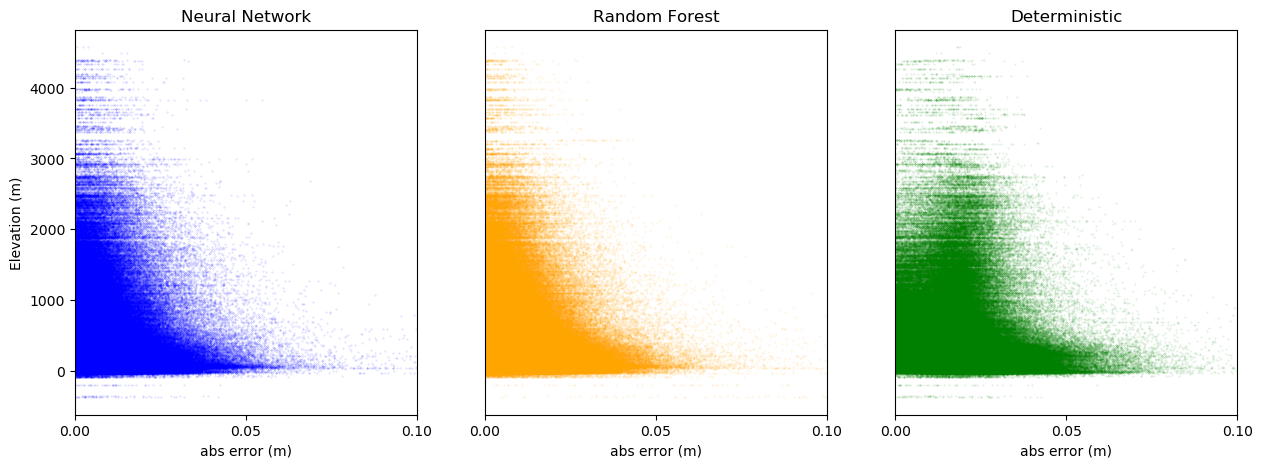

In [190]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

axes[0].scatter(np.abs(new_test.nn_model_prediction- new_test.ZTD), new_test.Hgt_m, c='blue', s=0.1, alpha=0.2)
axes[1].scatter(np.abs(new_test.rf_Model_prediction- new_test.ZTD), new_test.Hgt_m, c='orange', s=0.1, alpha=0.2)
axes[2].scatter(np.abs(new_test.WM_ZTD- new_test.ZTD), new_test.Hgt_m, c='green', s=0.1, alpha=0.2)
axes[0].set_title('Neural Network')
axes[1].set_title('Random Forest')
axes[2].set_title('Deterministic')
for num ,i in enumerate(axes):
    if num==0:
        i.set_ylabel('Elevation (m)', fontsize=10)
    else:
        i.set_yticks([])
    i.set_xlim(0,0.1)
    i.set_xticks([0, 0.05, 0.1])
    i.set_xlabel('abs error (m)')
fig.savefig('Plots/Abs_resid_by_model.png', dpi=300)
plt.show()

## Residual through time

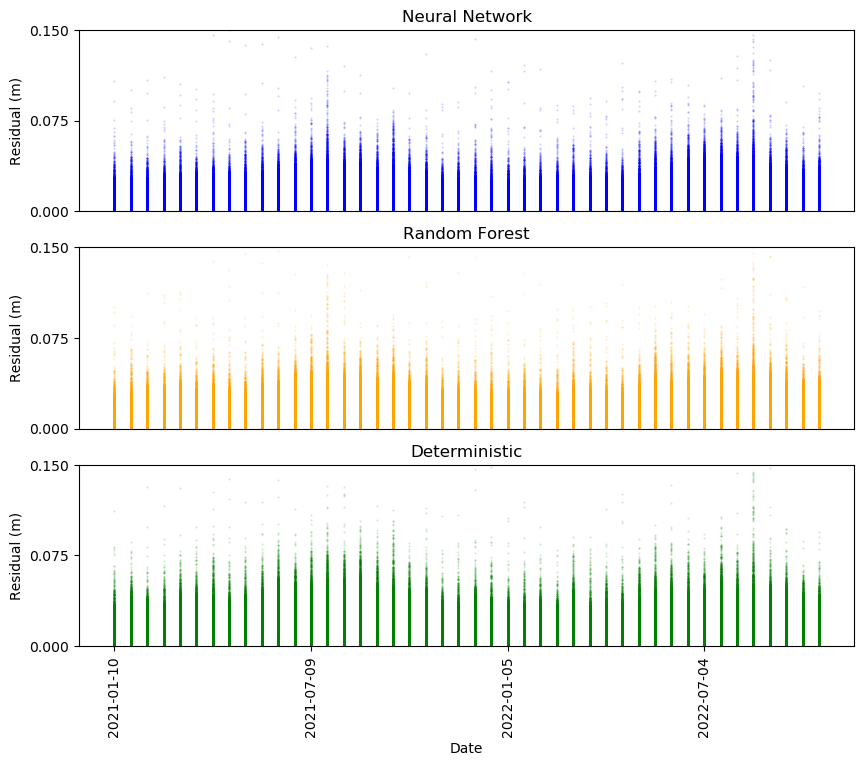

In [204]:
fig, axes=plt.subplots(3,1, figsize=(10,8))
axes[0].scatter(new_test.Date.values, np.abs(new_test.nn_model_prediction- new_test.ZTD).values, s=0.2, alpha=0.2, c='blue')
axes[1].scatter(new_test.Date.values, np.abs(new_test.rf_Model_prediction- new_test.ZTD).values, s=0.2, alpha=0.2, c='orange')
axes[2].scatter(new_test.Date.values, np.abs(new_test.WM_ZTD- new_test.ZTD).values, s=0.2, alpha=0.2, c='green')
axes[0].set_title('Neural Network')
axes[1].set_title('Random Forest')
axes[2].set_title('Deterministic')
for num ,i in enumerate(axes):
    if num==2:
        i.set_xticks(np.unique(new_test.Date)[::12])
        i.set_xticklabels(np.unique(new_test.Date)[::12], rotation=90)
        i.set_xlabel('Date')
    else:
        i.set_xticks([])
    i.set_ylim(0, 0.15)
    i.set_yticks([0,0.075,0.15])
    i.set_ylabel('Residual (m)', fontsize=10)

# fig.savefig('Plots/Abs_resid_by_model.png', dpi=300)
plt.show()

# Metric by Continent

Use pandas to read in the categrozied station by continent which we can merge these information with the other dataframe

In [94]:
station_con = pd.read_csv('station_continent.csv')
station_con.head()

ID CONTINENT
0  0ABI    Africa
1  0ABY    Europe
2  0AKE    Europe
3  0ALE    Europe
4  0ALF    Europe

In [98]:
new_test_continent = pd.merge(new_test, station_con, on=["ID"])

In [100]:
new_test_continent.head()

Unnamed: 0    ID        Date     ZTD  wet_delay  hydrostatic_delay  times  \
0     1082502  D143  2021-01-10  2.2784     0.0470             2.2314      0   
1     1093335  D143  2021-01-25  2.2190     0.0394             2.1796      0   
2     1103948  D143  2021-02-09  2.2150     0.0346             2.1804      0   
3     1114353  D143  2021-02-24  2.3439     0.0836             2.2603      0   
4     1125022  D143  2021-03-11  2.2942     0.0825             2.2117      0   

   sigZTD      Lat      Lon  ...      e_47      e_48      e_49      e_50  \
0  0.0026  50.7323  12.5203  ...  0.023558  0.012157  0.006304  0.002424   
1  0.0026  50.7323  12.5203  ...  0.025330  0.012363  0.006484  0.002100   
2  0.0027  50.7323  12.5203  ...  0.024498  0.012435  0.006266  0.003011   
3  0.0024  50.7323  12.5203  ...  0.026464  0.011949  0.006317  0.003030   
4  0.0026  50.7323  12.5203  ...  0.023908  0.011930  0.006138  0.002986   

       e_51  rf_Model_prediction  nn_model_prediction    WM_ZTD  id_station  \
0 -0.001055             2.267286             2.267729  2.273620        D143   
1 -0.002192             2.210145             2.213663  2.223226        D143   
2  0.001116             2.205041             2.197710  2.223079        D143   
3  0.001441             2.339764             2.346157  2.349665        D143   
4  0.001048             2.297924             2.289177  2.303688        D143   

   CONTINENT  
0     Europe  
1     Europe  
2     Europe  
3     Europe  
4     Europe  

[5 rows x 169 columns]

Getting the error metric terms by continent using groupby

In [101]:
error_by_cont = new_test_continent.groupby('CONTINENT').mean()[['Lat', 'Lon', 'Hgt_m', 'ZTD', 'nn_model_prediction', 'rf_Model_prediction', 'WM_ZTD']]

/tmp/ipykernel_11782/155992541.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  error_by_cont = new_test_continent.groupby('CONTINENT').mean()[['Lat', 'Lon', 'Hgt_m', 'ZTD', 'nn_model_prediction', 'rf_Model_prediction', 'WM_ZTD']]


In [103]:
error_by_cont

Lat         Lon        Hgt_m       ZTD  \
CONTINENT                                                     
Africa        -18.934643   25.177078   908.964215  2.226969   
Antarctica    -72.988403  -14.619101  1103.859299  1.961652   
Asia           35.210525  132.122478   235.710163  2.407307   
Europe         49.044924   11.111037   298.876530  2.344685   
North America  40.012555 -101.165861   508.835520  2.290436   
Oceania       -33.844432  149.427749   324.868400  2.355742   
South America -24.213387  -61.736892   551.603210  2.331754   

               nn_model_prediction  rf_Model_prediction    WM_ZTD  \
CONTINENT                                                           
Africa                    2.223148             2.220630  2.234679   
Antarctica                1.956838             1.962375  1.981388   
Asia                      2.400014             2.401448  2.413058   
Europe                    2.336842             2.338836  2.347643   
North America             2.290989             2.295006  2.311161   
Oceania                   2.354521             2.353934  2.364755   
South America             2.329060             2.328027  2.340198   

               nn_Avg_error  
CONTINENT                    
Africa            -0.003821  
Antarctica        -0.004814  
Asia              -0.007293  
Europe            -0.007844  
North America      0.000553  
Oceania           -0.001222  
South America     -0.002694

In [106]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

def rmse(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['nn_model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse_(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['rf_Model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse__(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['WM_ZTD']))
    return pd.Series(dict(rmse = rmse))

In [107]:
error_by_cont['nn_Avg_error'] = (new_test_continent.nn_model_prediction-new_test_continent.ZTD).groupby(new_test_continent['CONTINENT']).mean()
error_by_cont['nn_RMSE'] = new_test_continent.groupby('CONTINENT').apply(rmse)['rmse']
error_by_cont['rf_Avg_error'] = (new_test_continent.rf_Model_prediction-new_test_continent.ZTD).groupby(new_test_continent['CONTINENT']).mean()
error_by_cont['rf_RMSE'] = new_test_continent.groupby('CONTINENT').apply(rmse_)['rmse']
error_by_cont['wm_Avg_error'] = (new_test_continent.WM_ZTD-new_test_continent.ZTD).groupby(new_test_continent['CONTINENT']).mean()
error_by_cont['wm_RMSE'] = new_test_continent.groupby('CONTINENT').apply(rmse__)['rmse']

In [108]:
error_by_cont = error_by_cont.reset_index()

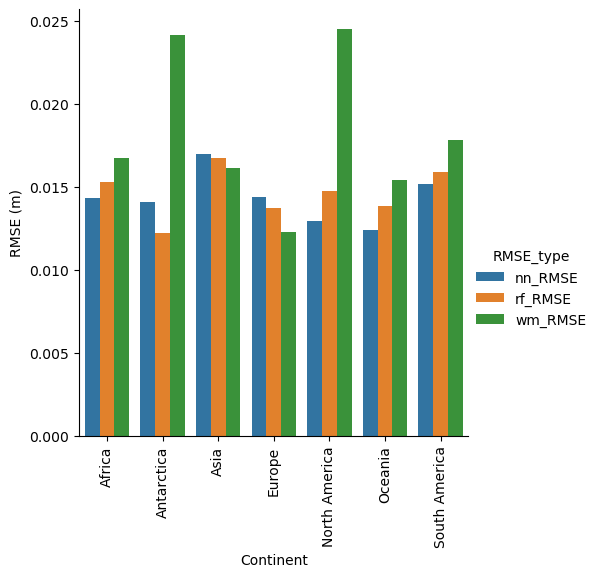

In [109]:
piv_df = error_by_cont.melt(id_vars=["Lat", "Lon","Hgt_m", "ZTD", "nn_model_prediction", "rf_Model_prediction", "WM_ZTD", "CONTINENT"], 
        var_name="RMSE_type", 
        value_name="RMSE").reset_index(drop=True)

import seaborn as sns
ax = sns.catplot(x = 'CONTINENT', y='RMSE', 
            hue = 'RMSE_type',data=piv_df[piv_df['RMSE_type'].isin(['nn_RMSE', 'rf_RMSE', 'wm_RMSE'])], 
            kind='bar').set(xlabel='Continent',ylabel='RMSE (m)')
ax.set_xticklabels(rotation=90) 
plt.show()

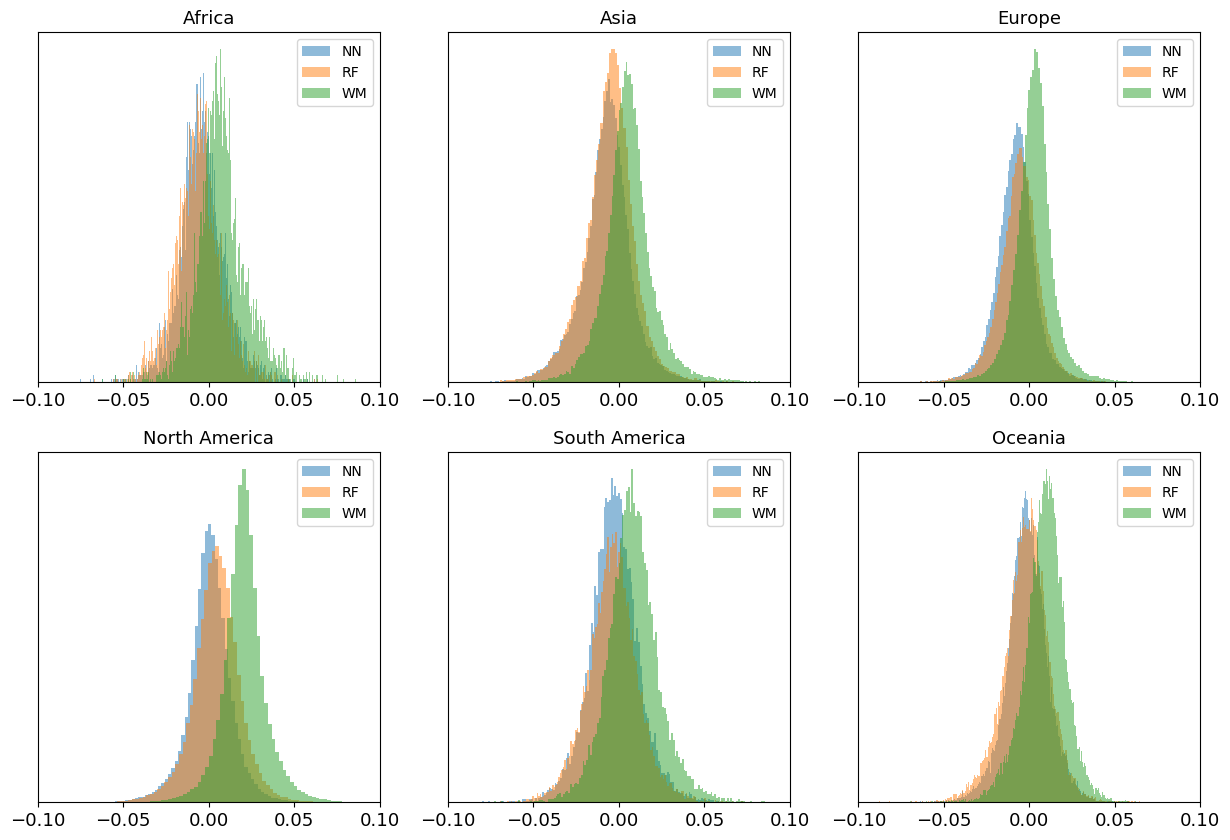

In [115]:
fig, axes=plt.subplots(2,3, figsize=(15,10))
label_size = 13
axes[0,0].set_title('Africa', fontsize=label_size)
axes[0,0].hist(new_test_continent[new_test_continent['CONTINENT']=='Africa'].nn_model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='Africa'].ZTD, bins=250, alpha=0.5, label='NN')
axes[0,0].hist(new_test_continent[new_test_continent['CONTINENT']=='Africa'].rf_Model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='Africa'].ZTD, bins=250, alpha=0.5, label ='RF')
axes[0,0].hist(new_test_continent[new_test_continent['CONTINENT']=='Africa'].WM_ZTD - 
               new_test_continent[new_test_continent['CONTINENT']=='Africa'].ZTD, bins=250, alpha=0.5, label='WM')
axes[0,0].xaxis.set_tick_params(labelsize=label_size)
axes[0,0].set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
axes[0,0].set_yticks([])
axes[0,0].legend(loc='upper right')
# axes[0,1].hist(new_test_continent[new_test_continent['CONTINENT']=='Antartica'].nn_model_prediction - 
#                new_test_continent[new_test_continent['CONTINENT']=='Antartica'].ZTD, bins=250)
# axes[0,1].hist(new_test_continent[new_test_continent['CONTINENT']=='Antartica'].rf_Model_prediction - 
#                new_test_continent[new_test_continent['CONTINENT']=='Antartica'].ZTD, bins=250)
axes[0,1].set_title('Asia', fontsize=label_size)
axes[0,1].hist(new_test_continent[new_test_continent['CONTINENT']=='Asia'].nn_model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='Asia'].ZTD, bins=250, alpha=0.5, label='NN')
axes[0,1].hist(new_test_continent[new_test_continent['CONTINENT']=='Asia'].rf_Model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='Asia'].ZTD, bins=250, alpha=0.5, label ='RF')
axes[0,1].hist(new_test_continent[new_test_continent['CONTINENT']=='Asia'].WM_ZTD - 
               new_test_continent[new_test_continent['CONTINENT']=='Asia'].ZTD, bins=250, alpha=0.5, label='WM')
axes[0,1].xaxis.set_tick_params(labelsize=label_size)
axes[0,1].set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
axes[0,1].set_yticks([])
axes[0,1].legend(loc='upper right')
axes[0,2].set_title('Europe', fontsize=label_size)
axes[0,2].hist(new_test_continent[new_test_continent['CONTINENT']=='Europe'].nn_model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='Europe'].ZTD, bins=250, alpha=0.5, label='NN')
axes[0,2].hist(new_test_continent[new_test_continent['CONTINENT']=='Europe'].rf_Model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='Europe'].ZTD, bins=250, alpha=0.5, label ='RF')
axes[0,2].hist(new_test_continent[new_test_continent['CONTINENT']=='Europe'].WM_ZTD - 
               new_test_continent[new_test_continent['CONTINENT']=='Europe'].ZTD, bins=250, alpha=0.5, label='WM')
axes[0,2].xaxis.set_tick_params(labelsize=label_size)
axes[0,2].set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
axes[0,2].set_yticks([])
axes[0,2].legend(loc='upper right')
axes[1,0].set_title('North America', fontsize=label_size)
axes[1,0].hist(new_test_continent[new_test_continent['CONTINENT']=='North America'].nn_model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='North America'].ZTD, bins=250, alpha=0.5, label='NN')
axes[1,0].hist(new_test_continent[new_test_continent['CONTINENT']=='North America'].rf_Model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='North America'].ZTD, bins=250, alpha=0.5, label ='RF')
axes[1,0].hist(new_test_continent[new_test_continent['CONTINENT']=='North America'].WM_ZTD - 
               new_test_continent[new_test_continent['CONTINENT']=='North America'].ZTD, bins=250, alpha=0.5, label='WM')
axes[1,0].xaxis.set_tick_params(labelsize=label_size)
axes[1,0].set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
axes[1,0].set_yticks([])
axes[1,0].legend(loc='upper right')
axes[1,1].set_title('South America', fontsize=label_size)
axes[1,1].hist(new_test_continent[new_test_continent['CONTINENT']=='South America'].nn_model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='South America'].ZTD, bins=250, alpha=0.5, label='NN')
axes[1,1].hist(new_test_continent[new_test_continent['CONTINENT']=='South America'].rf_Model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='South America'].ZTD, bins=250, alpha=0.5, label ='RF')
axes[1,1].hist(new_test_continent[new_test_continent['CONTINENT']=='South America'].WM_ZTD - 
               new_test_continent[new_test_continent['CONTINENT']=='South America'].ZTD, bins=250, alpha=0.5, label='WM')
axes[1,1].xaxis.set_tick_params(labelsize=label_size)
axes[1,1].set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
axes[1,1].set_yticks([])
axes[1,1].legend(loc='upper right')
axes[1,2].set_title('Oceania', fontsize=label_size)
axes[1,2].hist(new_test_continent[new_test_continent['CONTINENT']=='Oceania'].nn_model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='Oceania'].ZTD, bins=250, alpha=0.5, label='NN')
axes[1,2].hist(new_test_continent[new_test_continent['CONTINENT']=='Oceania'].rf_Model_prediction - 
               new_test_continent[new_test_continent['CONTINENT']=='Oceania'].ZTD, bins=250, alpha=0.5, label ='RF')
axes[1,2].hist(new_test_continent[new_test_continent['CONTINENT']=='Oceania'].WM_ZTD - 
               new_test_continent[new_test_continent['CONTINENT']=='Oceania'].ZTD, bins=250, alpha=0.5, label='WM')
axes[1,2].xaxis.set_tick_params(labelsize=label_size)
axes[1,2].set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
axes[1,2].set_yticks([])
axes[1,2].legend(loc='upper right')
plt.setp(axes, xlim=(-0.1, 0.1))
fig.savefig('Plots/Residual_by_continent.png', dpi=250)
plt.show()

# RAiDER bias testing on CONUS

In [87]:
utc_6 = pd.read_csv('../GNSS_US/US_UTC_6/GNSS/UNRcombinedGPS_ztd.csv')

In [116]:
import glob
import xarray as xr
import rasterio
weather_file_path = '../GNSS_US/US_UTC_6/weather_files/'
utc_6['WM_ZTD'] = 0
dates_ = np.unique(utc_6.Date.values)
for i, date in enumerate(dates_):
    print(date)
    df = utc_6[utc_6['Date']==date]
    loc = np.hstack((df.Lon.values.reshape(-1,1), df.Lat.values.reshape(-1,1), df.Hgt_m.values.reshape(-1,1)))
    with xr.load_dataset(" ".join(glob.glob(weather_file_path + 'ERA-5_{date}_T06_00_00*[A-Z].nc'.format(date=date.replace('-', '_'))))) as wm:
        hydro_total_1_interp = make_interpretor(wm, 'hydro_total')
        wet_total_1_interp = make_interpretor(wm, 'wet_total')
  
    hydro1 = hydro_total_1_interp(loc)
    wet1 = wet_total_1_interp(loc)
    td1 = hydro1 + wet1
    utc_6.loc[utc_6.groupby('Date').get_group(date).index,'WM_ZTD'] = td1
    

2017-01-01
2017-01-16
2017-01-31
2017-02-15
2017-03-02
2017-03-17
2017-04-01
2017-04-16
2017-05-01
2017-05-16
2017-05-31
2017-06-15
2017-06-30
2017-07-15
2017-07-30
2017-08-14
2017-08-29
2017-09-13
2017-09-28
2017-10-13
2017-10-28
2017-11-12
2017-11-27
2017-12-12
2017-12-27
2018-01-11
2018-01-26
2018-02-10
2018-02-25
2018-03-12
2018-03-27
2018-04-11
2018-04-26
2018-05-11
2018-05-26
2018-06-10
2018-06-25
2018-07-10
2018-07-25
2018-08-09
2018-08-24
2018-09-08
2018-09-23
2018-10-08
2018-10-23
2018-11-07
2018-11-22
2018-12-07
2018-12-22
2019-01-06
2019-01-21
2019-02-05
2019-02-20
2019-03-07
2019-03-22
2019-04-06
2019-04-21
2019-05-06
2019-05-21
2019-06-05
2019-06-20
2019-07-05
2019-07-20
2019-08-04
2019-08-19
2019-09-03
2019-09-18
2019-10-03
2019-10-18
2019-11-02
2019-11-17
2019-12-02
2019-12-17
2020-01-01
2020-01-16
2020-01-31
2020-02-15
2020-03-01
2020-03-16
2020-03-31
2020-04-15
2020-04-30
2020-05-15
2020-05-30
2020-06-14
2020-06-29
2020-07-14
2020-07-29
2020-08-13
2020-08-28
2020-09-12

In [99]:
utc_6

ID        Date     ZTD  wet_delay  hydrostatic_delay  times  sigZTD  \
0       14T1  2021-03-11  2.4168     0.1236             2.2932  21600  0.0017   
1       1LSU  2017-04-01  2.4121     0.1057             2.3064  21600  0.0025   
2       1LSU  2017-04-16  2.5237     0.2028             2.3209  21600  0.0027   
3       1LSU  2017-05-01  2.3576     0.0502             2.3074  21600  0.0026   
4       1LSU  2017-05-16  2.4437     0.1329             2.3108  21600  0.0025   
...      ...         ...     ...        ...                ...    ...     ...   
578672  ZUMB  2022-11-01  2.2915     0.0724             2.2191  21600  0.0018   
578673  ZUMB  2022-11-16  2.2932     0.0548             2.2384  21600  0.0018   
578674  ZUMB  2022-12-01  2.2729     0.0234             2.2495  21600  0.0016   
578675  ZUMB  2022-12-16  2.2258     0.0483             2.1775  21600  0.0015   
578676  ZUMB  2022-12-31  2.2567     0.0370             2.2197  21600  0.0017   

            Lat      Lon    Hgt_m    WM_ZTD  
0       45.4001 -75.9194   45.260  2.431951  
1       30.4074 -91.1803   -6.487  2.424443  
2       30.4074 -91.1803   -6.487  2.553064  
3       30.4074 -91.1803   -6.487  2.352915  
4       30.4074 -91.1803   -6.487  2.465099  
...         ...      ...      ...       ...  
578672  44.2907 -92.6813  295.980  2.314388  
578673  44.2907 -92.6813  295.980  2.311771  
578674  44.2907 -92.6813  295.980  2.289077  
578675  44.2907 -92.6813  295.980  2.248988  
578676  44.2907 -92.6813  295.980  2.279253  

[578677 rows x 11 columns]

In [153]:
from sklearn.metrics import mean_squared_error, r2_score
print("UTC_6 model")
predict = utc_6.WM_ZTD
true = utc_6.ZTD
# The mean squared error
print('Mean squared error: %.10f' % mean_squared_error(true, predict))
print('Mean: %.5f' % np.mean(predict-true))

# The R2 score
print('R2: %.5f' % r2_score(true, predict))

# The RMSE
rmse = np.sqrt(mean_squared_error(true, predict-(2.5/100)))
print('RMSE: %.5f' % rmse)

errors = predict - true
MAE = np.mean(abs(errors))
print('MAE: %.5f' % MAE )

UTC_6 model
Mean squared error: 0.0015943553
Mean: 0.02626
R2: 0.95902
RMSE: 0.03011
MAE: 0.02663


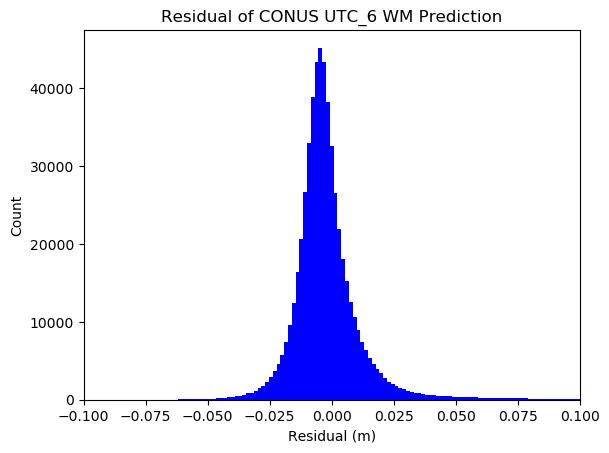

In [154]:
plt.hist(predict-(2.5/100)-true, bins=450, color='blue')
plt.title('Residual of CONUS UTC_6 WM Prediction')
plt.xlabel('Residual (m)')
plt.ylabel('Count')
plt.xlim(-0.1, 0.1)
# plt.text(-0.09, 400000, 'RMSE: {:.5f} m\n MAE: {:.5f} m \n MEAN: {:.5f} m'.format(0.00972, 0.00678, 0.00039 ), fontsize = 8, 
#          bbox = dict(facecolor = 'white', alpha = 0.5))
plt.show()

In [106]:
error_by_station_ = utc_6.groupby('ID').mean()[['Lat', 'Lon', 'Hgt_m', 'ZTD', 'WM_ZTD']]

/tmp/ipykernel_18838/3230183749.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  error_by_station_ = utc_6.groupby('ID').mean()[['Lat', 'Lon', 'Hgt_m', 'ZTD', 'WM_ZTD']]


In [107]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error

def rmse(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['nn_model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse_(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['rf_model_prediction']))
    return pd.Series(dict(rmse = rmse))
def rmse__(g):
    # r2 = r2_score(g['ZTD'], g['Model_prediction'])
    rmse = np.sqrt(mean_squared_error(g['ZTD'], g['WM_ZTD']))
    return pd.Series(dict(rmse = rmse))

In [111]:
# error_by_station['nn_Avg_error'] = (test_US.nn_model_prediction-test_US.ZTD).groupby(test_US['ID']).mean()
# error_by_station['nn_RMSE'] = test_US.groupby('ID').apply(rmse)['rmse']
# error_by_station['rf_Avg_error'] = (test_US.rf_model_prediction-test_US.ZTD).groupby(test_US['ID']).mean()
# error_by_station['rf_RMSE'] = test_US.groupby('ID').apply(rmse_)['rmse']
error_by_station_['wm_Avg_error'] = (utc_6.WM_ZTD-utc_6.ZTD).groupby(utc_6['ID']).mean()
error_by_station_['wm_RMSE'] = utc_6.groupby('ID').apply(rmse__)['rmse']

In [109]:
error_by_station_

Lat       Lon     Hgt_m       ZTD    WM_ZTD  wm_Avg_error   wm_RMSE
ID                                                                           
14T1  45.4001  -75.9194    45.260  2.416800  2.431951      0.015151  0.015151
1LSU  30.4074  -91.1803    -6.487  2.503352  2.527270      0.023919  0.050552
1NSU  31.7508  -93.0976    28.071  2.478801  2.497865      0.019064  0.032627
1ULM  32.5290  -92.0759    16.000  2.477518  2.498503      0.020985  0.032689
59WE  33.4311 -112.1831   289.115  2.330079  2.352876      0.022797  0.024941
...       ...       ...       ...       ...       ...           ...       ...
ZOB1  41.2972  -82.2064   223.618  2.355874  2.393174      0.037299  0.056155
ZOLE  39.4217 -119.7534  1357.313  1.992253  2.049613      0.057361  0.068044
ZTL4  33.3797  -84.2967   261.134  2.393965  2.428607      0.034641  0.051123
ZUMA  37.5582 -117.4902  1924.552  1.845435  1.899402      0.053967  0.060225
ZUMB  44.2907  -92.6813   295.980  2.332103  2.354951      0.022848  0.024480

[5796 rows x 7 columns]

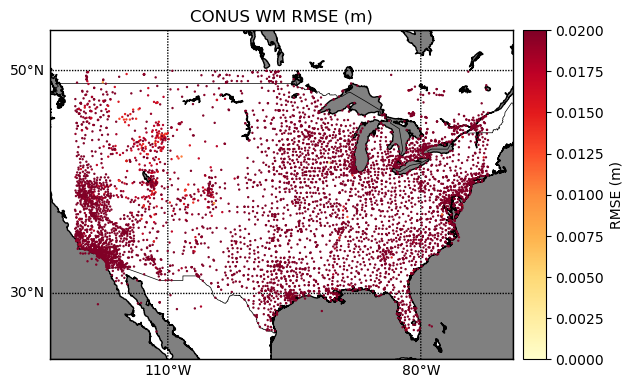

In [112]:
# day1 = day1[(day1['Lat'] >30) & (day1['Lat'] < 60) & ((day1['Lon'] > -120) & (day1['Lon'] < -60))]
lat = error_by_station_['Lat']
lon = error_by_station_['Lon']

# determine range to print based on min, max lat and lon of the data
margin = 3 # buffer to add to the range
lat_min = min(lat) - margin
lat_max = max(lat) + margin
lon_min = min(lon) - margin
lon_max = max(lon) + margin

# create map using BASEMAP
m = Basemap(llcrnrlon=lon_min,
            llcrnrlat=lat_min,
            urcrnrlon=lon_max,
            urcrnrlat=lat_max,
            lat_0=0,
            lon_0=0,
            projection='merc',
            resolution = 'i',
            area_thresh=1000
            )
m.drawcoastlines()
m.drawcountries()
# m.drawstates()
m.drawmapboundary(fill_color='grey')
m.fillcontinents(color = 'white',lake_color='grey')
# draw parallels and meridians.
# label parallels on right and top
# meridians on bottom and left
parallels = np.arange(-90,90,20)
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[True,False,False,True])
meridians = np.arange(10.,351.,30)
m.drawmeridians(meridians,labels=[True,False,False,True])
# convert lat and lon to map projection coordinates
lons, lats = m(lon, lat)
# plot points as red dots
m.scatter(lons, lats, marker = '.', c=error_by_station_['wm_RMSE'], cmap='YlOrRd', s=2, zorder=5, vmin=0, vmax=0.02)
m.colorbar(label='RMSE (m)')
plt.title('CONUS WM RMSE (m)')
# plt.savefig('Plots/CONUS_RF_RMSE.png', dpi=250)
plt.show()

## Bias in general

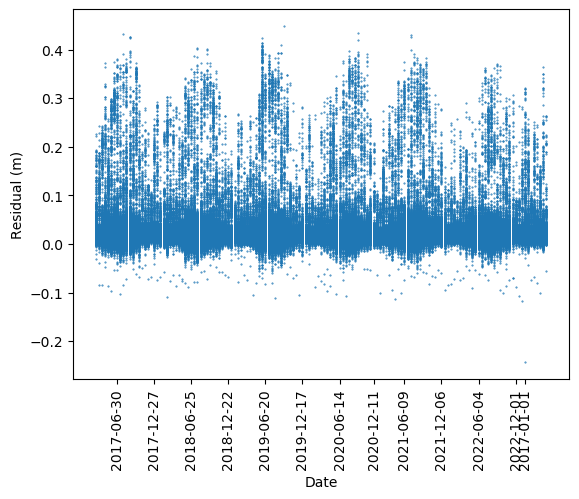

In [162]:
plt.scatter(utc_6.Date.values, (utc_6.WM_ZTD- utc_6.ZTD).values, s=0.2)
plt.xticks(np.unique(utc_6.Date)[::12], rotation=90)
plt.xlabel('Date')
plt.ylabel('Residual (m)')
# plt.title(station)
plt.show()

In [159]:
np.unique(utc_6.Date)[::12]

array(['2017-01-01', '2017-06-30', '2017-12-27', '2018-06-25',
       '2018-12-22', '2019-06-20', '2019-12-17', '2020-06-14',
       '2020-12-11', '2021-06-09', '2021-12-06', '2022-06-04',
       '2022-12-01'], dtype=object)

## Bias of one station

In [148]:
station = "ZOB1"
spec_df = utc_6[utc_6['ID']==station]

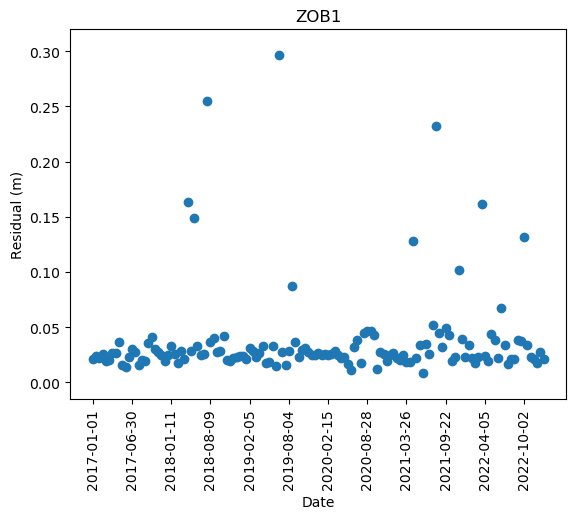

In [155]:
plt.scatter(spec_df.Date, spec_df.WM_ZTD- spec_df.ZTD)
plt.xticks(spec_df.Date[::12], rotation=90)
plt.xlabel('Date')
plt.ylabel('Residual (m)')
plt.title(station)
plt.show()

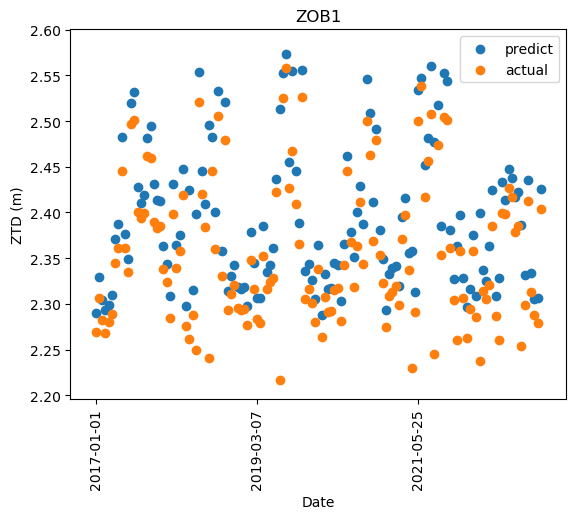

In [152]:
plt.scatter(spec_df.Date, spec_df.WM_ZTD, label='predict')
plt.scatter(spec_df.Date, spec_df.ZTD, label='actual')
plt.xticks(spec_df.Date[::50], rotation=90)
plt.xlabel('Date')
plt.ylabel('ZTD (m)')
plt.title(station)
plt.legend()
plt.show()